In [2]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [3]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [8]:
# Mac
path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [4]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [5]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [6]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [ ]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

100%|██████████| 1/1 [00:00<00:00, 399.61it/s]


In [17]:
basins_problems2 = pd.read_csv(r"..\data\basins_problems_filter_2.csv")
basins_problems2

,basin
0,AT000080
1,AT000120
2,AT000159
3,AT000372
4,AT000373
...,...
369,SE000083
370,SE000103
371,SE000118
372,SI000029


In [18]:
Outliers = ["DEBB0050", 
"DK000087",
"ES000172",
"ES000478",
"ES001114",
"FI000202",
"FI000506",
"FR001271",
"FR001475",
"ITIS0107",
"NL000012",
"PT000211",
"PT000218",
"PT000263",
"DEHE0953",
"DEHE0970",
"DEHE0989",
"DEHE1008",
"DEHE1013",
"DEHE1014",
"DK000094"]

In [20]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.index.isin(basins_problems2.basin)]

estreams_attributes_clipped_filters2

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR000183,A900105050,A9001050,FR,FR_EAUFRANCE,La Sarre à Laneuveville-lès-Lorquin,7.008689,48.654579,7.008689,48.654579,268,...,5.440,0.000,0.000,4.0,66.0,29.0,5.0,64.0,30.0,6.0
FR003252,A631101001,La Meurthe Ã Azerailles et Ã Baccarat,FR,FR_EAUFRANCE,La Meurthe à Azerailles et à Baccarat,6.738613,48.449237,6.738613,48.449237,260,...,6.226,0.004,0.007,9.0,59.0,0.0,41.0,56.0,17.0,27.0
FR003254,A643112001,La Vezouze Ã BlÃ¢mont et Ã FrÃ©monville,FR,FR_EAUFRANCE,La Vezouze à Blâmont et à Frémonville,6.843861,48.588049,6.843861,48.588049,265,...,5.071,0.000,0.001,4.0,64.0,36.0,0.0,63.0,37.0,0.0


In [ ]:
# Create a folder to save the plots
output_dir = r"..\results\plots"
os.makedirs(output_dir, exist_ok=True)

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    csv_file = fr"C:\Users\nascimth\Documents\data\EStreams\data\estreams_timeseries_{basin_id}.csv"
    
    df = pd.read_csv(csv_file)
    
    column_name = basin_id
    
    # Ensure the first column is treated as the Date index
    df.set_index(df.columns[0], inplace=True)
    df = df.loc["1988-10-01":"2015-09-30"]

    # Plotting
    plt.figure(figsize=(10, 4))
    df['q_mean'].plot(linewidth=0.5)
    plt.title(f"Basin: {basin_id}")
    plt.xlabel("Date")
    plt.ylabel("q_mean")
    #plt.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f"{basin_id}.png")
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid overlap in next iteration

100%|██████████| 112/112 [00:17<00:00,  6.53it/s]


In [19]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters[~estreams_attributes_clipped_filters.index.isin(basins_problems2.basin)]

estreams_attributes_clipped_filters2

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,7.497,1.400,3.429,16.0,3.0,3.0,94.0,75.0,25.0,0.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,8.920,0.000,0.075,8.0,2.0,0.0,98.0,64.0,36.0,0.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,6.106,0.000,0.000,6.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,7.096,1.200,2.427,9.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,6.996,0.200,0.605,6.0,4.0,15.0,81.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,5.680,0.045,0.045,25.0,2.0,0.0,98.0,100.0,0.0,0.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,2.863,0.004,0.009,15.0,14.0,86.0,0.0,0.0,100.0,0.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,4.753,1.641,4.770,78.0,19.0,31.0,50.0,41.0,59.0,0.0


In [9]:
estreams_attributes_clipped_filters

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,7.497,1.400,3.429,16.0,3.0,3.0,94.0,75.0,25.0,0.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,8.920,0.000,0.075,8.0,2.0,0.0,98.0,64.0,36.0,0.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,6.106,0.000,0.000,6.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,7.096,1.200,2.427,9.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,6.996,0.200,0.605,6.0,4.0,15.0,81.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,5.680,0.045,0.045,25.0,2.0,0.0,98.0,100.0,0.0,0.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,2.863,0.004,0.009,15.0,14.0,86.0,0.0,0.0,100.0,0.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,4.753,1.641,4.770,78.0,19.0,31.0,50.0,41.0,59.0,0.0


In [10]:
# Folder where time series are stored
data_folder = r"C:\Users\nascimth\Documents\data\EStreams\data"

# Initialize list to collect Gantt data
gantt_data = []

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    file_path = os.path.join(data_folder, f"estreams_timeseries_{basin_id}.csv")
    
    # Load and parse date index
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    
    # Clip to desired date range
    data = data.loc["1988-10-01":"2015-09-30"]
    
    # Drop NaNs in q_mean
    valid_q = data["q_mean"].dropna()
    
    if not valid_q.empty:
        start_date = valid_q.index.min()
        end_date = valid_q.index.max()
        gantt_data.append((basin_id, start_date, end_date))

# Convert to DataFrame
gantt_df = pd.DataFrame(gantt_data, columns=["basin", "start", "end"])

100%|██████████| 112/112 [00:05<00:00, 22.29it/s]


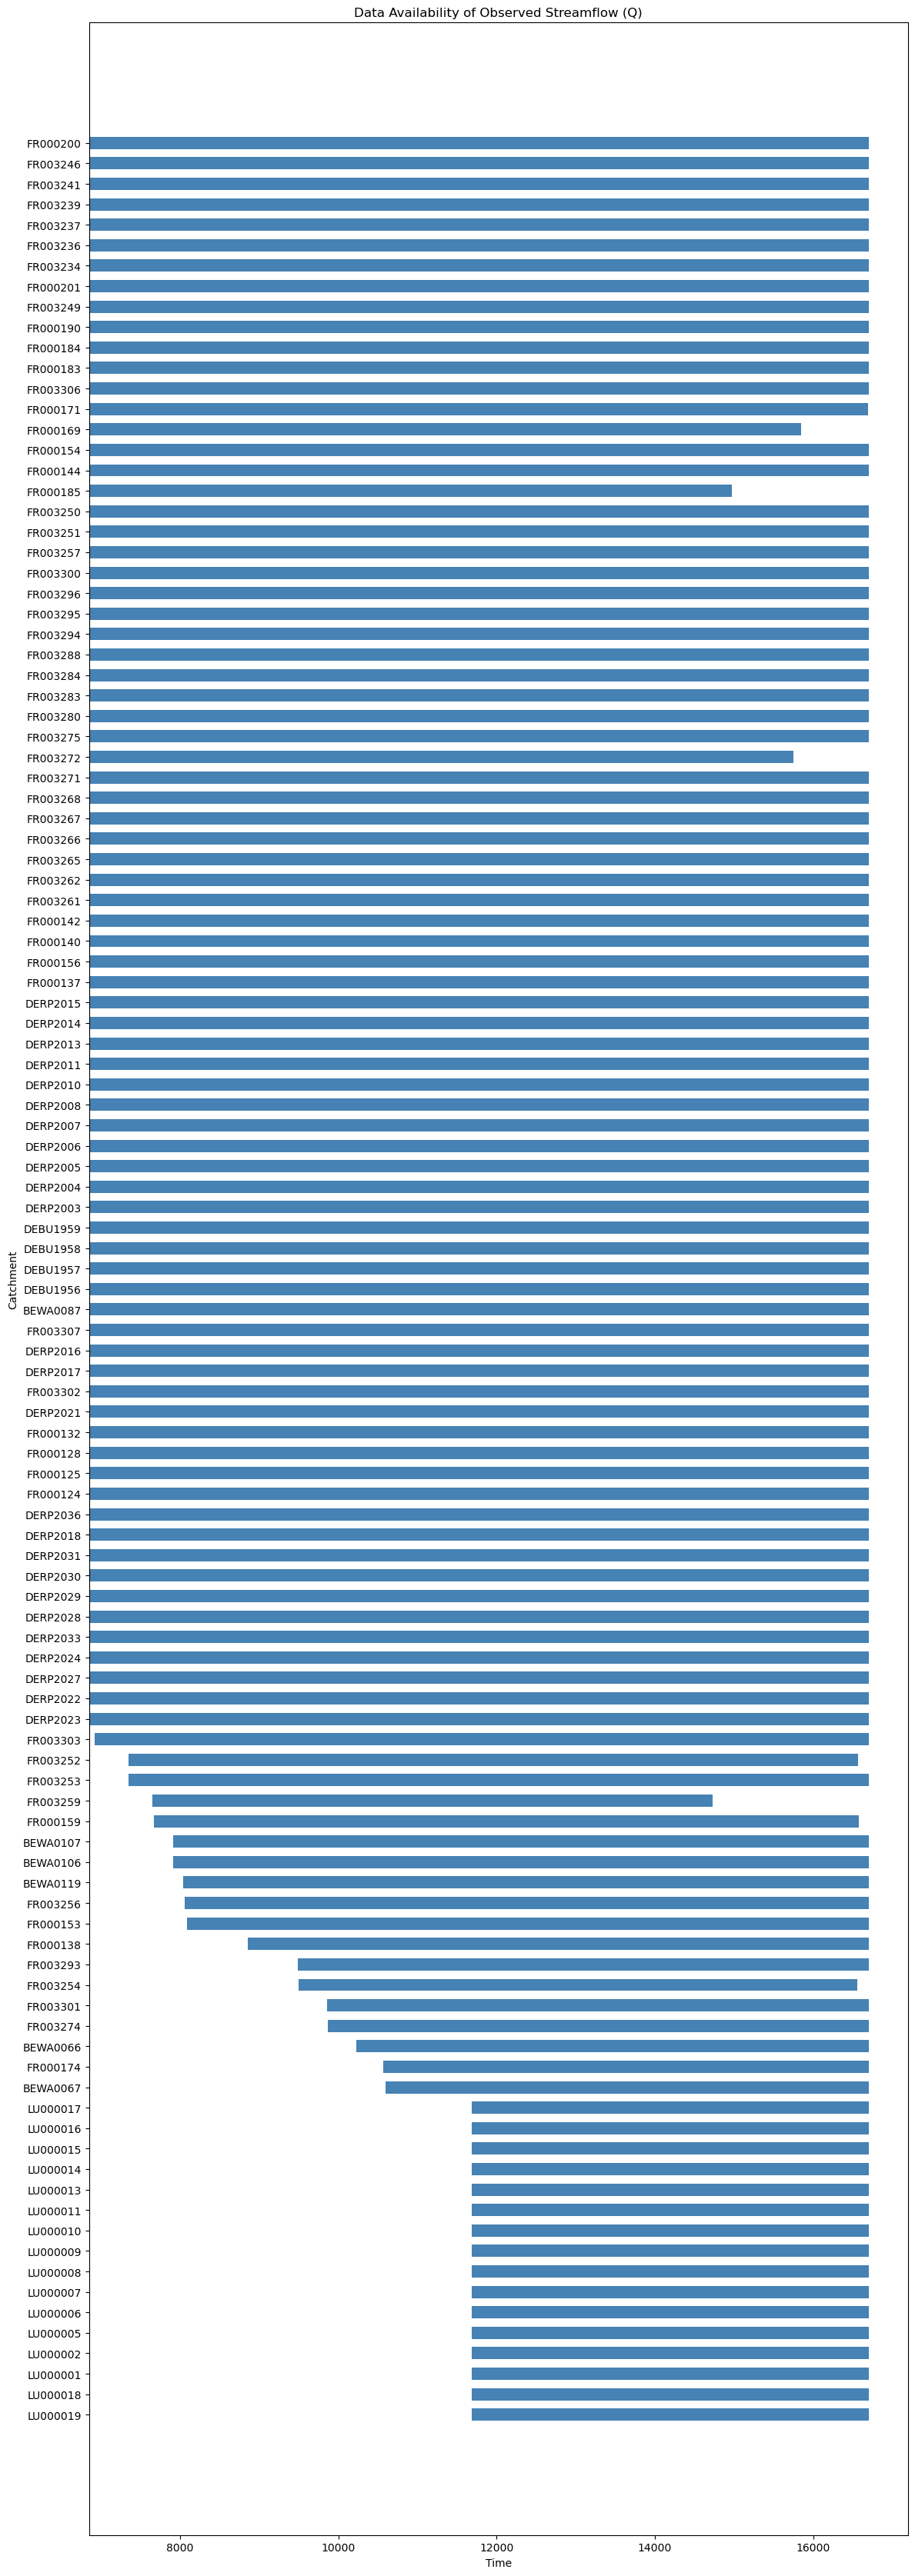

In [12]:
import matplotlib.pyplot as plt

# Sort by start date for prettier layout
gantt_df = gantt_df.sort_values("start")

# Plot
fig, ax = plt.subplots(figsize=(12, len(gantt_df) * 0.3))

for i, row in gantt_df.iterrows():
    ax.barh(y=row["basin"], left=row["start"], width=(row["end"] - row["start"]).days, height=0.6, color="steelblue")

ax.set_xlabel("Time")
ax.set_ylabel("Catchment")
ax.set_title("Data Availability of Observed Streamflow (Q)")
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

In [9]:
# Python implementation
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [238]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general'
)

low = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [fast],
    ],
    id='low'
)

high = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [slowhigh],
    ],
    id='high'
)

In [11]:
data_text = """"
high_snow_k,3.0543392206359528
high_unsaturated_Smax,152.24836010494946
high_unsaturated_Ce,1.0201279161858614
high_unsaturated_beta,0.8113683893845915
high_slowhigh_k,6.440000000017071e-05
general_snow_k,3.0543392206359528
general_unsaturated_Smax,152.24836010494946
general_unsaturated_Ce,1.0201279161858614
general_unsaturated_beta,0.8113683893845915
general_lowersplitter_splitpar,0.5010000000005239
general_slow_k,0.08185382689099417
general_lag-fun_lag-time,2.9579108997419956
general_fast_k,0.19437734859985495
low_snow_k,3.0543392206359528
low_unsaturated_Smax,152.24836010494946
low_unsaturated_Ce,1.0201279161858614
low_unsaturated_beta,0.8113683893845915
low_fast_k,0.004677629904959929
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_1[key] = float(value)
    else:
        1+1

In [90]:
data_text = """"
high_snow_k,2.930483638554881
high_unsaturated_Smax,225.18897907157685
high_unsaturated_Ce,1.0536277651792032
high_unsaturated_beta,0.7300765922948531
high_slowhigh_k,0.00011700000000005459
general_snow_k,2.930483638554881
general_unsaturated_Smax,225.18897907157685
general_unsaturated_Ce,1.0536277651792032
general_unsaturated_beta,0.7300765922948531
general_lowersplitter_splitpar,0.5000000000002116
general_slow_k,0.08714500573429074
general_lag-fun_lag-time,3.1148512951889744
general_fast_k,0.12911429342224337
low_snow_k,2.930483638554881
low_unsaturated_Smax,225.18897907157685
low_unsaturated_Ce,1.0536277651792032
low_unsaturated_beta,0.7300765922948531
low_fast_k,0.0038291109489411277
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_2 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_2[key] = float(value)
    else:
        1+1

In [12]:
data_text = """"
high_snow_k,3.0365740485599746
high_unsaturated_Smax,130.90402428074796
high_unsaturated_Ce,0.8092303247092076
high_unsaturated_beta,1.5981931455431173
high_slowhigh_k,9.585047986416182e-06
general_snow_k,3.0365740485599746
general_unsaturated_Smax,130.90402428074796
general_unsaturated_Ce,0.8092303247092076
general_unsaturated_beta,1.5981931455431173
general_lowersplitter_splitpar,0.5002909989743869
general_slow_k,0.09504795526553368
general_lag-fun_lag-time,3.0060458116305644
general_fast_k,0.174061039082191
low_snow_k,3.0365740485599746
low_unsaturated_Smax,130.90402428074796
low_unsaturated_Ce,0.8092303247092076
low_unsaturated_beta,1.5981931455431173
low_fast_k,0.0026826026287785727
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_c_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_c_1[key] = float(value)
    else:
        1+1

In [91]:
data_text = """"
high_snow_k,2.816090235103266
high_unsaturated_Smax,147.12262769630658
high_unsaturated_Ce,0.859437565650947
high_unsaturated_beta,1.5652684405415664
high_slowhigh_k,6.080000000005174e-06
general_snow_k,2.816090235103266
general_unsaturated_Smax,147.12262769630658
general_unsaturated_Ce,0.859437565650947
general_unsaturated_beta,1.5652684405415664
general_lowersplitter_splitpar,0.5000000000005562
general_slow_k,0.09020931666141896
general_lag-fun_lag-time,3.2466419583880897
general_fast_k,0.12610318592232778
low_snow_k,2.816090235103266
low_unsaturated_Smax,147.12262769630658
low_unsaturated_Ce,0.859437565650947
low_unsaturated_beta,1.5652684405415664
low_fast_k,0.003517160476395025
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_c_2 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_c_2[key] = float(value)
    else:
        1+1

In [13]:
data_text = """"
high_snow_k,3.129337493750535
high_unsaturated_Smax,168.00409428701926
high_unsaturated_Ce,1.043907419074948
high_unsaturated_beta,0.73367631928306
high_slowhigh_k,9.890000000120205e-05
general_snow_k,3.129337493750535
general_unsaturated_Smax,168.00409428701926
general_unsaturated_Ce,1.043907419074948
general_unsaturated_beta,0.73367631928306
general_lowersplitter_splitpar,0.5000000000058183
general_slow_k,0.09989999999688552
general_lag-fun_lag-time,2.7009939230510938
general_fast_k,0.14802065632512057
low_snow_k,3.129337493750535
low_unsaturated_Smax,168.00409428701926
low_unsaturated_Ce,1.043907419074948
low_unsaturated_beta,0.73367631928306
low_fast_k,0.0017011312853222357
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_g_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_g_1[key] = float(value)
    else:
        1+1

In [93]:
data_text = """"
high_snow_k,3.262444069619977
high_unsaturated_Smax,206.91420858545695
high_unsaturated_Ce,1.0427091279541725
high_unsaturated_beta,0.781430183022324
high_slowhigh_k,8.100000000294766e-05
general_snow_k,3.262444069619977
general_unsaturated_Smax,206.91420858545695
general_unsaturated_Ce,1.0427091279541725
general_unsaturated_beta,0.781430183022324
general_lowersplitter_splitpar,0.5000000000046407
general_slow_k,0.09999999999039748
general_lag-fun_lag-time,3.000000026983848
general_fast_k,0.09911399448457683
low_snow_k,3.262444069619977
low_unsaturated_Smax,206.91420858545695
low_unsaturated_Ce,1.0427091279541725
low_unsaturated_beta,0.781430183022324
low_fast_k,0.0024597195111422583
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_g_2 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_g_2[key] = float(value)
    else:
        1+1

In [14]:
data_text = """"
high_snow_k,1.8121421490422898
high_unsaturated_Smax,170.94520666797803
high_unsaturated_Ce,1.5126970857997835
high_unsaturated_beta,0.6004304969509585
high_slowhigh_k,4.860000000135867e-05
general_snow_k,1.8121421490422898
general_unsaturated_Smax,170.94520666797803
general_unsaturated_Ce,1.5126970857997835
general_unsaturated_beta,0.6004304969509585
general_lowersplitter_splitpar,0.5000000000028926
general_slow_k,0.09979999999254877
general_lag-fun_lag-time,2.934475849503587
general_fast_k,0.15128733585069815
low_snow_k,1.8121421490422898
low_unsaturated_Smax,170.94520666797803
low_unsaturated_Ce,1.5126970857997835
low_unsaturated_beta,0.6004304969509585
low_fast_k,0.0017664553718867307
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_g_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_g_1_8801[key] = float(value)
    else:
        1+1


In [94]:
data_text = """"
high_snow_k,1.637202012278872
high_unsaturated_Smax,177.43145962682792
high_unsaturated_Ce,1.2412223531421205
high_unsaturated_beta,0.8241121879648012
high_slowhigh_k,2.370000000076929e-05
general_snow_k,1.637202012278872
general_unsaturated_Smax,177.43145962682792
general_unsaturated_Ce,1.2412223531421205
general_unsaturated_beta,0.8241121879648012
general_lowersplitter_splitpar,0.50000000000143
general_slow_k,0.09989999999503327
general_lag-fun_lag-time,3.0140864425334994
general_fast_k,0.06503693054917867
low_snow_k,1.637202012278872
low_unsaturated_Smax,177.43145962682792
low_unsaturated_Ce,1.2412223531421205
low_unsaturated_beta,0.8241121879648012
low_fast_k,0.002695720010184143
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_g_2_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_g_2_8801[key] = float(value)
    else:
        1+1


In [15]:
data_text = """"
high_snow_k,1.843545894902258
high_unsaturated_Smax,122.71792975383084
high_unsaturated_Ce,1.3680658998241941
high_unsaturated_beta,0.8488477126426069
high_slowhigh_k,1.870921744063965e-05
general_snow_k,1.843545894902258
general_unsaturated_Smax,122.71792975383084
general_unsaturated_Ce,1.3680658998241941
general_unsaturated_beta,0.8488477126426069
general_lowersplitter_splitpar,0.5000242296469859
general_slow_k,0.09950731141761572
general_lag-fun_lag-time,2.999852241580967
general_fast_k,0.17984776225475138
low_snow_k,1.843545894902258
low_unsaturated_Smax,122.71792975383084
low_unsaturated_Ce,1.3680658998241941
low_unsaturated_beta,0.8488477126426069
low_fast_k,0.0033908514824536463
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_1_8801[key] = float(value)
    else:
        1+1


In [95]:
data_text = """"
high_snow_k,1.574877751167112
high_unsaturated_Smax,189.7900828022733
high_unsaturated_Ce,1.235114881285675
high_unsaturated_beta,0.7873304606057695
high_slowhigh_k,3.19000000001076e-05
general_snow_k,1.574877751167112
general_unsaturated_Smax,189.7900828022733
general_unsaturated_Ce,1.235114881285675
general_unsaturated_beta,0.7873304606057695
general_lowersplitter_splitpar,0.5000000000050095
general_slow_k,0.09568628655152381
general_lag-fun_lag-time,3.1321824521302313
general_fast_k,0.07772516534893224
low_snow_k,1.574877751167112
low_unsaturated_Smax,189.7900828022733
low_unsaturated_Ce,1.235114881285675
low_unsaturated_beta,0.7873304606057695
low_fast_k,0.0033233384382156776
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_2_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_2_8801[key] = float(value)
    else:
        1+1


In [16]:
data_text = """"
high_snow_k,1.9174317304928352
high_unsaturated_Smax,254.96192182128095
high_unsaturated_Ce,1.456779237824005
high_unsaturated_beta,0.5141538084067014
high_slowhigh_k,7.720000000024317e-05
general_snow_k,1.9174317304928352
general_unsaturated_Smax,254.96192182128095
general_unsaturated_Ce,1.456779237824005
general_unsaturated_beta,0.5141538084067014
general_lowersplitter_splitpar,0.5000000000065525
general_slow_k,0.09202077289900594
general_lag-fun_lag-time,3.000000000165407
general_fast_k,0.1582823173142503
low_snow_k,1.9174317304928352
low_unsaturated_Smax,254.96192182128095
low_unsaturated_Ce,1.456779237824005
low_unsaturated_beta,0.5141538084067014
low_fast_k,0.0025172333012943656
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_c_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_c_1_8801[key] = float(value)
    else:
        1+1


In [96]:
data_text = """"
high_snow_k,1.5602300589422828
high_unsaturated_Smax,182.82124963950903
high_unsaturated_Ce,1.1905112530597644
high_unsaturated_beta,0.8585662596061674
high_slowhigh_k,1.940000000000317e-05
general_snow_k,1.5602300589422828
general_unsaturated_Smax,182.82124963950903
general_unsaturated_Ce,1.1905112530597644
general_unsaturated_beta,0.8585662596061674
general_lowersplitter_splitpar,0.5000000000009273
general_slow_k,0.0887175275992245
general_lag-fun_lag-time,3.1947058232970633
general_fast_k,0.07667373600303945
low_snow_k,1.5602300589422828
low_unsaturated_Smax,182.82124963950903
low_unsaturated_Ce,1.1905112530597644
low_unsaturated_beta,0.8585662596061674
low_fast_k,0.0031919474719931894
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_c_2_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_c_2_8801[key] = float(value)
    else:
        1+1


In [239]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

def calculate_hydro_year(date, first_month=10):
    """
    This function calculates the hydrological year from a date. The
    hydrological year starts on the month defined by the parameter first_month.

    Parameters
    ----------
    date : pandas.core.indexes.datetimes.DatetimeIndex
        Date series
    first_month : int
        Number of the first month of the hydrological year

    Returns
    -------
    numpy.ndarray
        Hydrological year time series
    """

    hydrological_year = date.year.values.copy()
    hydrological_year[date.month >= first_month] += 1

    return hydrological_year

def run_model_superflexpy(catchments_ids, best_params_dict_model, perm_areas_model):
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    
    general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general')

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low')

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high')

    for cat_id in catchments_ids:
        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs

    model.set_timestep(1.0)
    model.set_parameters(best_params_dict_model)

    output = model.get_output()

    return output



def generate_nse_results(catchments_ids, daterange, output, observations, quality_masks):


    # Create an empty list to store results
    nse_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        hydro_year = calculate_hydro_year(date=Qtimeseries.index, first_month=10)

        nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values, 
                                    expo=0.5)
                
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        qmean_obs = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])
        qmean_sim = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])
        
        try:

            slope_obs = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])["Sawicz"]
            slope_sim = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])["Sawicz"]
        except: 
            slope_obs = np.nan
            slope_sim = np.nan
        
        try:
            hfd_obs = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]
            hfd_sim = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]

        except:
            hfd_obs = np.nan
            hfd_sim = np.nan

        try:            
            nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    expo=0.5)
        except:
            nse_value_bfi = np.nan


        nse_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "nse": nse_value,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "nse_value_bfi": nse_value_bfi,
            "qmean_obs": qmean_obs,
            "qmean_sim": qmean_sim,
            "slope_obs": slope_obs,
            "slope_sim": slope_sim,
            "hfd_obs": hfd_obs,
            "hfd_sim": hfd_sim
            })

    # Convert results to DataFrame
    nse_results_df = pd.DataFrame(nse_results_cal)

    return nse_results_df

In [19]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas_model = perm_areas)
output_continental = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1, perm_areas_model = perm_areascontinental)
output_global = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas_model = perm_areasglobal)

In [244]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_global = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas_model = perm_areasglobal)

In [20]:
nse_results_cal_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional, observations, quality_masks)
nse_results_cal_c_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_continental, observations, quality_masks)
nse_results_cal_g_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_global, observations, quality_masks)

In [133]:
nse_results_cal_r_1_100.iloc[0:10]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.848794,0.514795,0.548222,0.864637,1.238351,1.163753,3.347668,2.688420,125.769231,131.846154
1,Schoenberg,BEWA0067,0.802846,0.448057,0.530274,0.815041,1.412586,1.264227,3.448610,2.755547,122.307692,131.846154
2,Martelange,BEWA0087,-19.559708,0.715474,0.514520,NaN,0.196649,1.218498,1.740044,2.755850,149.666667,125.416667
3,Reuland,BEWA0106,0.771835,0.481832,0.549566,NaN,1.011804,0.901341,4.246454,2.674293,126.153846,132.769231
4,Lommersweiler,BEWA0107,0.733169,0.569622,0.545603,NaN,1.142034,1.248445,3.281075,2.697986,131.250000,134.000000
5,Ouren,BEWA0119,0.833193,0.505083,0.546002,NaN,1.195583,1.153048,3.519631,2.679689,121.100000,128.700000
6,BundespegelPerl,DEBU1956,0.859238,0.614257,0.630691,0.896368,0.966259,0.999730,2.414206,2.430191,131.000000,133.230769
7,BundespegelFremersdorf,DEBU1957,0.877524,0.609906,0.648814,0.881482,0.782447,0.773315,2.116811,2.328942,132.923077,137.461538
8,BundespegelTrierUp,DEBU1958,0.899955,0.626954,0.634029,0.926625,0.938375,0.916868,2.401219,2.380774,131.230769,133.615385
9,BundespegelCochem,DEBU1959,0.875305,0.615673,0.634569,0.923445,0.897177,0.895242,2.589688,2.371684,131.461538,133.538462


In [23]:
nse_results_cal_g_1_100

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.605018,0.514795,0.774018,0.359489,1.238351,1.153959,3.347668,1.698767,125.769231,153.076923
1,Schoenberg,BEWA0067,0.595109,0.448057,0.724424,0.294567,1.412586,1.252292,3.448610,1.879314,122.307692,149.000000
2,Martelange,BEWA0087,-17.802514,0.715474,0.805247,NaN,0.196649,1.204538,1.740044,1.795489,149.666667,153.083333
3,Reuland,BEWA0106,0.373415,0.481832,0.824887,NaN,1.011804,0.896802,4.246454,1.577711,126.153846,162.615385
4,Lommersweiler,BEWA0107,0.461108,0.569622,0.805443,NaN,1.142034,1.237714,3.281075,1.574802,131.250000,159.916667
...,...,...,...,...,...,...,...,...,...,...,...,...
107,Michelau,LU000015,0.470379,0.524064,0.821986,0.131107,1.040332,1.009407,4.286267,1.713605,121.769231,158.692308
108,Pfaffenthal,LU000016,0.624536,0.567054,0.495767,0.075348,0.801764,0.740867,2.023796,3.257105,133.615385,129.000000
109,Rosport,LU000017,0.812067,0.577206,0.689589,0.791339,0.935842,0.889729,2.468492,1.921953,127.307692,144.153846
110,Schoenfels,LU000018,0.589691,0.549042,0.492088,-0.006511,0.876011,0.789468,2.255653,3.193161,127.384615,128.692308


In [24]:
nse_results_cal_c_1_100

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.871418,0.514795,0.565795,0.893489,1.238351,1.235518,3.347668,2.829824,125.769231,127.923077
1,Schoenberg,BEWA0067,0.809580,0.448057,0.552260,0.801821,1.412586,1.349172,3.448610,2.812811,122.307692,127.615385
2,Martelange,BEWA0087,-20.952601,0.715474,0.541796,NaN,0.196649,1.271732,1.740044,3.133023,149.666667,123.500000
3,Reuland,BEWA0106,0.808807,0.481832,0.573125,NaN,1.011804,0.929902,4.246454,3.102713,126.153846,131.692308
4,Lommersweiler,BEWA0107,0.755168,0.569622,0.559026,NaN,1.142034,1.332646,3.281075,2.829186,131.250000,129.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
107,Michelau,LU000015,0.846317,0.524064,0.564715,0.860806,1.040332,1.053635,4.286267,3.103233,121.769231,127.384615
108,Pfaffenthal,LU000016,0.568545,0.567054,0.518546,-0.007240,0.801764,0.740971,2.023796,3.633578,133.615385,128.692308
109,Rosport,LU000017,0.871857,0.577206,0.612385,0.865723,0.935842,0.917307,2.468492,2.545581,127.307692,132.461538
110,Schoenfels,LU000018,0.303242,0.549042,0.871740,-0.479965,0.876011,0.790487,2.255653,1.054332,127.384615,170.615385


In [194]:
nse_results_cal_g_1_100

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim
0,Reuland,BEWA0066,0.509680,1.238351,1.413764,0.514795,0.801690,-0.226092,1.238351,1.413764
1,Schoenberg,BEWA0067,0.537730,1.412586,1.551060,0.448057,0.749340,-0.297544,1.412586,1.551060
2,Martelange,BEWA0087,-23.463574,0.196649,1.416387,0.715474,0.833118,NaN,0.196649,1.417446
3,Reuland,BEWA0106,0.222121,1.011804,1.041629,0.481832,0.848318,NaN,1.011804,1.041613
4,Lommersweiler,BEWA0107,0.245898,1.142034,1.527285,0.569622,0.835007,NaN,1.142034,1.525417
...,...,...,...,...,...,...,...,...,...,...
107,Michelau,LU000015,0.286873,1.040332,1.170369,0.524064,0.848358,-0.491782,1.040332,1.170369
108,Pfaffenthal,LU000016,0.350317,0.801764,0.730492,0.567054,0.496831,-0.916501,0.801764,0.730492
109,Rosport,LU000017,0.739243,0.935842,0.997709,0.577206,0.708731,0.443414,0.935842,0.997709
110,Schoenfels,LU000018,0.326556,0.876011,0.793484,0.549042,0.494346,-1.192283,0.876011,0.793484


In [25]:
nse_results_cal_g_1_100.iloc[:, 2:].corr()

,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
nse,1.000000,-0.210705,-0.194202,0.931156,0.175546,-0.021343,0.128298,0.137237,-0.232291,-0.181723
bfi_obs,-0.210705,1.000000,0.432119,-0.367124,0.003834,0.052186,-0.740555,-0.399630,0.795295,0.304083
bfi_sim,-0.194202,0.432119,1.000000,-0.258398,0.033675,0.120636,-0.088878,-0.960159,0.422664,0.912653
nse_value_bfi,0.931156,-0.367124,-0.258398,1.000000,0.270761,0.164499,0.286249,0.109380,-0.423072,-0.342118
qmean_obs,0.175546,0.003834,0.033675,0.270761,1.000000,0.933752,0.035492,-0.126718,0.015162,-0.054575
qmean_sim,-0.021343,0.052186,0.120636,0.164499,0.933752,1.000000,0.013839,-0.204404,0.054814,0.007272
slope_obs,0.128298,-0.740555,-0.088878,0.286249,0.035492,0.013839,1.000000,0.132651,-0.598611,-0.002074
slope_sim,0.137237,-0.399630,-0.960159,0.109380,-0.126718,-0.204404,0.132651,1.000000,-0.406355,-0.877488
hfd_obs,-0.232291,0.795295,0.422664,-0.423072,0.015162,0.054814,-0.598611,-0.406355,1.000000,0.453135
hfd_sim,-0.181723,0.304083,0.912653,-0.342118,-0.054575,0.007272,-0.002074,-0.877488,0.453135,1.000000


In [26]:
nse_results_cal_c_1_100.iloc[:, 2:].corr()

,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
nse,1.000000,-0.220712,0.014856,0.975919,0.169664,-0.028588,0.155457,-0.015374,-0.236567,0.019199
bfi_obs,-0.220712,1.000000,0.501890,-0.522706,0.003834,0.060642,-0.740555,-0.477648,0.795295,0.492849
bfi_sim,0.014856,0.501890,1.000000,-0.541692,-0.195377,-0.168545,-0.512912,-0.925542,0.506521,0.947849
nse_value_bfi,0.975919,-0.522706,-0.541692,1.000000,0.370602,0.270118,0.523604,0.327102,-0.589640,-0.688090
qmean_obs,0.169664,0.003834,-0.195377,0.370602,1.000000,0.933557,0.035492,-0.040954,0.015162,-0.204943
qmean_sim,-0.028588,0.060642,-0.168545,0.270118,0.933557,1.000000,0.012227,-0.080437,0.066476,-0.193165
slope_obs,0.155457,-0.740555,-0.512912,0.523604,0.035492,0.012227,1.000000,0.533975,-0.598611,-0.500185
slope_sim,-0.015374,-0.477648,-0.925542,0.327102,-0.040954,-0.080437,0.533975,1.000000,-0.474249,-0.817566
hfd_obs,-0.236567,0.795295,0.506521,-0.589640,0.015162,0.066476,-0.598611,-0.474249,1.000000,0.590845
hfd_sim,0.019199,0.492849,0.947849,-0.688090,-0.204943,-0.193165,-0.500185,-0.817566,0.590845,1.000000


In [27]:
nse_results_cal_r_1_100.iloc[:, 2:].corr()

,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
nse,1.000000,-0.219492,0.057010,0.974912,0.166885,-0.031292,0.148685,-0.023586,-0.238807,0.048660
bfi_obs,-0.219492,1.000000,0.663958,-0.575693,0.003834,0.052587,-0.740555,-0.621218,0.795295,0.570241
bfi_sim,0.057010,0.663958,1.000000,-0.593453,-0.178632,-0.127207,-0.609391,-0.922330,0.658540,0.912433
nse_value_bfi,0.974912,-0.575693,-0.593453,1.000000,0.335240,0.205298,0.507587,0.469503,-0.647708,-0.680217
qmean_obs,0.166885,0.003834,-0.178632,0.335240,1.000000,0.933302,0.035492,0.016281,0.015162,-0.144725
qmean_sim,-0.031292,0.052587,-0.127207,0.205298,0.933302,1.000000,0.014669,-0.046625,0.054780,-0.121268
slope_obs,0.148685,-0.740555,-0.609391,0.507587,0.035492,0.014669,1.000000,0.612453,-0.598611,-0.525037
slope_sim,-0.023586,-0.621218,-0.922330,0.469503,0.016281,-0.046625,0.612453,1.000000,-0.625188,-0.849059
hfd_obs,-0.238807,0.795295,0.658540,-0.647708,0.015162,0.054780,-0.598611,-0.625188,1.000000,0.743389
hfd_sim,0.048660,0.570241,0.912433,-0.680217,-0.144725,-0.121268,-0.525037,-0.849059,0.743389,1.000000


In [28]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1_8801, perm_areas_model = perm_areas)
output_continental_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1_8801, perm_areas_model = perm_areascontinental)
output_global_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1_8801, perm_areas_model = perm_areasglobal)

In [33]:
nse_results_cal_r_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_8801, observations, quality_masks)
nse_results_cal_c_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_continental_8801, observations, quality_masks)
nse_results_cal_g_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_global_8801, observations, quality_masks)

c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_18512\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:1

In [37]:
path_inputs = '../data/models/input/subset_1988_2001'

observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'

observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

In [38]:
observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

output_regional_cal = {
    key: [np.concatenate([output_regional_8801[key][0], output_regional[key][0]])]
    for key in output_regional_8801
    if key in output_regional  # ensures keys match
}

output_continental_cal = {
    key: [np.concatenate([output_continental_8801[key][0], output_continental[key][0]])]
    for key in output_continental_8801
    if key in output_continental  # ensures keys match
}

output_global_cal = {
    key: [np.concatenate([output_global_8801[key][0], output_global[key][0]])]
    for key in output_global_8801
    if key in output_global  # ensures keys match
}

In [39]:
nse_results_cal_r_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_cal, observations_cal, quality_masks_cal)

In [40]:
nse_results_cal_c_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_cal, observations_cal, quality_masks_cal)

In [41]:
nse_results_cal_g_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_cal, observations_cal, quality_masks_cal)

In [42]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [43]:
data_diff_cal_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_c_1_100_complete_cal.nse)
data_diff_cal_complete["nse_rg"] = nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_g_1_100_complete_cal.nse

data_diff_cal_complete.index = nse_results_cal_c_1_100_complete_cal.basin

data_diff_cal_complete = data_diff_cal_complete.loc[~data_diff_cal_complete.index.isin(list_cal)]

data_diff_cal_complete["nse_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete["nse_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete["nse_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse

data_diff_cal_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_obs
data_diff_cal_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim

data_diff_cal_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_obs
data_diff_cal_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim

data_diff_cal_complete["slope_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_obs
data_diff_cal_complete["slope_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete["slope_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete["slope_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).slope_sim

data_diff_cal_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_obs
data_diff_cal_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim


data_diff_cal_complete = data_diff_cal_complete[data_diff_cal_complete.nse_r1 > -10.0]
data_diff_cal_complete

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.001149,0.268031,0.851093,0.852243,0.583063,NaN,NaN,NaN,0.515742,0.548718,...,1.351956,1.288932,3.400558,2.976367,2.934487,1.821173,126.294118,131.882353,130.882353,154.176471
BEWA0067,0.009853,0.222910,0.809852,0.799998,0.586941,NaN,NaN,NaN,0.446878,0.532464,...,1.448924,1.376110,3.527884,2.993893,2.914022,1.935750,123.437500,132.562500,131.000000,150.500000
BEWA0106,0.006073,0.412047,0.781766,0.775693,0.369718,NaN,NaN,NaN,0.496805,0.547567,...,1.054775,1.029473,4.063631,3.047146,2.840718,1.628205,127.000000,131.260870,134.739130,163.347826
BEWA0107,-0.014334,0.288461,0.738470,0.752804,0.450010,NaN,NaN,NaN,0.565063,0.536430,...,1.453730,1.372933,3.418299,3.027440,2.860948,1.713635,133.588235,135.705882,134.823529,162.411765
BEWA0119,0.005936,0.264379,0.835513,0.829577,0.571134,NaN,NaN,NaN,0.508101,0.543373,...,1.349761,1.303859,3.336434,3.008043,2.868014,1.877872,123.266667,131.000000,131.600000,152.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.063811,0.324573,0.788203,0.852015,0.463630,NaN,NaN,NaN,0.516853,0.540057,...,1.078589,1.032389,4.331634,2.780046,3.182454,1.750002,121.769231,128.615385,127.384615,158.692308
LU000016,0.101071,0.046878,0.688581,0.587510,0.641703,NaN,NaN,NaN,0.564940,0.548115,...,0.754176,0.754024,2.005883,2.865947,3.677462,3.265085,133.615385,130.846154,128.692308,129.000000
LU000017,-0.007480,0.057143,0.867416,0.874896,0.810273,NaN,NaN,NaN,0.572433,0.589466,...,0.936887,0.912301,2.459555,2.478226,2.601025,1.956562,127.307692,133.000000,132.461538,144.153846


In [132]:
data_diff_cal_complete.iloc[0:10]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.001149,0.268031,0.851093,0.852243,0.583063,NaN,NaN,NaN,0.515742,0.548718,...,1.351956,1.288932,3.400558,2.976367,2.934487,1.821173,126.294118,131.882353,130.882353,154.176471
BEWA0067,0.009853,0.222910,0.809852,0.799998,0.586941,NaN,NaN,NaN,0.446878,0.532464,...,1.448924,1.376110,3.527884,2.993893,2.914022,1.935750,123.437500,132.562500,131.000000,150.500000
BEWA0106,0.006073,0.412047,0.781766,0.775693,0.369718,NaN,NaN,NaN,0.496805,0.547567,...,1.054775,1.029473,4.063631,3.047146,2.840718,1.628205,127.000000,131.260870,134.739130,163.347826
BEWA0107,-0.014334,0.288461,0.738470,0.752804,0.450010,NaN,NaN,NaN,0.565063,0.536430,...,1.453730,1.372933,3.418299,3.027440,2.860948,1.713635,133.588235,135.705882,134.823529,162.411765
BEWA0119,0.005936,0.264379,0.835513,0.829577,0.571134,NaN,NaN,NaN,0.508101,0.543373,...,1.349761,1.303859,3.336434,3.008043,2.868014,1.877872,123.266667,131.000000,131.600000,152.333333
DEBU1956,0.001204,-0.000377,0.873645,0.872441,0.874023,0.905270,0.894271,0.901646,0.602355,0.617071,...,1.097363,1.078885,2.505087,2.585635,2.600206,2.580150,132.038462,132.307692,132.923077,132.923077
DEBU1957,0.004165,0.004404,0.876563,0.872398,0.872159,0.861301,0.850039,0.855997,0.606413,0.638242,...,0.849564,0.849369,2.049171,2.349275,2.359390,2.380944,134.115385,135.115385,136.730769,135.461538
DEBU1959,-0.000759,0.000406,0.879101,0.879860,0.878696,0.918662,0.908779,0.915312,0.609882,0.620664,...,0.991965,0.980642,2.526058,2.530589,2.472063,2.395559,132.230769,132.230769,133.346154,134.384615
DERP2004,0.020763,0.202898,0.836786,0.816023,0.633888,0.854910,0.792016,0.286371,0.500196,0.547314,...,1.252370,1.218601,3.097860,2.993649,2.747625,1.870203,125.730769,130.500000,132.423077,150.615385


In [44]:
data_diff_cal_complete.corr()

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
nse,1.000000,-0.095856,0.021078,-0.315310,0.073474,-0.153460,-0.666302,-0.016717,0.104209,0.218743,...,-0.143401,-0.131706,-0.271189,-0.234638,-0.184487,0.119693,0.049926,0.202708,0.378171,-0.102173
nse_rg,-0.095856,1.000000,0.299583,0.316506,-0.237617,0.446928,0.415735,-0.428677,-0.272187,-0.322865,...,-0.086757,-0.107846,0.494187,0.219618,0.225398,-0.351570,-0.286209,-0.244034,-0.246574,0.525100
nse_r1,0.021078,0.299583,1.000000,0.942132,0.855559,0.890940,0.788972,0.504540,-0.470684,-0.434927,...,0.140839,0.132203,0.283813,0.287314,0.274172,0.075663,-0.648580,-0.545518,-0.499828,-0.171071
nse_c1,-0.315310,0.316506,0.942132,1.000000,0.787459,0.746341,0.912865,0.389314,-0.481716,-0.486180,...,0.181769,0.169650,0.360330,0.351396,0.322106,0.031684,-0.632373,-0.585777,-0.601244,-0.128120
nse_g1,0.073474,-0.237617,0.855559,0.787459,1.000000,0.595168,0.511666,0.862633,-0.331517,-0.267612,...,0.190468,0.193119,0.020797,0.173350,0.156833,0.267806,-0.505028,-0.422984,-0.375087,-0.459105
nse_bfi_r1,-0.153460,0.446928,0.890940,0.746341,0.595168,1.000000,0.790959,0.589401,-0.275951,-0.693271,...,0.214371,0.200418,0.390940,0.583549,0.592636,0.295212,-0.232050,-0.740331,-0.730178,-0.304198
nse_bfi_c1,-0.666302,0.415735,0.788972,0.912865,0.511666,0.790959,1.000000,0.408403,-0.327503,-0.588944,...,0.268037,0.257188,0.364455,0.528638,0.293976,0.268050,-0.300462,-0.612266,-0.518472,-0.223098
nse_bfi_g1,-0.016717,-0.428677,0.504540,0.389314,0.862633,0.589401,0.408403,1.000000,-0.152749,-0.307148,...,0.218346,0.215817,0.167115,0.246099,0.236333,0.587259,-0.190747,-0.381321,-0.366327,-0.712319
bfi_obs,0.104209,-0.272187,-0.470684,-0.481716,-0.331517,-0.275951,-0.327503,-0.152749,1.000000,0.655318,...,0.013524,0.017934,-0.709873,-0.624442,-0.460142,-0.388630,0.844838,0.592401,0.465045,0.262777
bfi_r1,0.218743,-0.322865,-0.434927,-0.486180,-0.267612,-0.693271,-0.588944,-0.307148,0.655318,1.000000,...,-0.121276,-0.111963,-0.581566,-0.943046,-0.828255,-0.543595,0.692726,0.940544,0.820813,0.436409


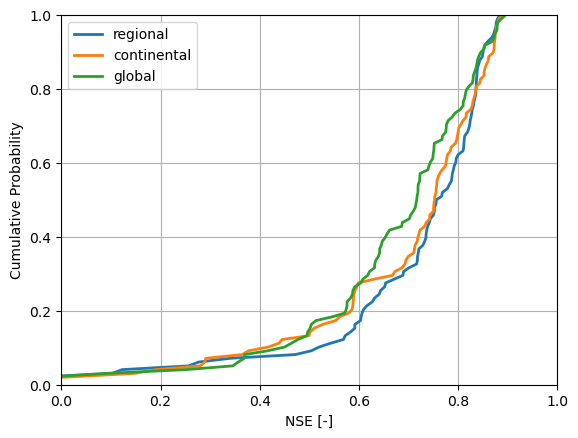

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


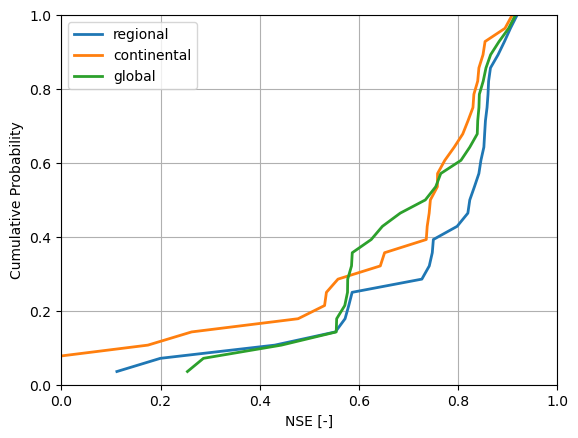

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [233]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_global_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas_model = perm_areasglobal)

KeyError: 'basin_id'

In [49]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas_model = perm_areas)
output_continental_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1, perm_areas_model = perm_areascontinental)
output_global_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas_model = perm_areasglobal)

In [232]:
output_global_val

{'BEWA0067': [array([0.        , 0.        , 0.        , ..., 1.43420321, 1.35772496,
         1.35753621])],
 'BEWA0087': [array([0.        , 0.        , 0.        , ..., 1.04626694, 1.05884347,
         1.06458952])],
 'BEWA0106': [array([0.        , 0.        , 0.        , ..., 0.95367295, 0.96755547,
         0.97405457])],
 'BEWA0107': [array([0.        , 0.        , 0.        , ..., 1.44785905, 1.44465381,
         1.44926332])],
 'DERP2005': [array([0.        , 0.        , 0.        , ..., 1.19263805, 1.06968369,
         1.15176871])],
 'DERP2006': [array([0.        , 0.        , 0.        , ..., 1.41840265, 1.24601655,
         1.26382325])],
 'DERP2008': [array([0.        , 0.        , 0.        , ..., 1.04356967, 0.93461015,
         0.98673011])],
 'DERP2010': [array([0.        , 0.        , 0.        , ..., 0.95553296, 0.87801705,
         0.91337989])],
 'DERP2013': [array([0.        , 0.        , 0.        , ..., 0.68904969, 0.69628085,
         0.68527222])],
 'DERP2015

In [50]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1_8801, perm_areas_model = perm_areas)
output_continental_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1_8801, perm_areas_model = perm_areascontinental)
output_global_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1_8801, perm_areas_model = perm_areasglobal)

In [51]:
output_regional_val_c = {
    key: [np.concatenate([output_regional_val[key][0], output_regional_0115[key][0]])]
    for key in output_regional_0115
    if key in output_regional_val  # ensures keys match
}

output_continental_val_c = {
    key: [np.concatenate([output_continental_val[key][0], output_continental_0115[key][0]])]
    for key in output_continental_val
    if key in output_continental_0115  # ensures keys match
}

output_global_val_c = {
    key: [np.concatenate([output_global_val[key][0], output_global_0115[key][0]])]
    for key in output_global_val
    if key in output_global_0115  # ensures keys match
}

In [52]:
nse_results_cal_r_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_val_c, observations_cal, quality_masks_cal)

In [53]:
nse_results_cal_c_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_val_c, observations_cal, quality_masks_cal)

In [54]:
nse_results_cal_g_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_val_c, observations_cal, quality_masks_cal)

In [55]:
data_diff_val_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_c_1_100_complete_val.nse)
data_diff_val_complete["nse_rg"] = nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_g_1_100_complete_val.nse

data_diff_val_complete.index = nse_results_cal_c_1_100_complete_val.basin

data_diff_val_complete = data_diff_val_complete.loc[~data_diff_val_complete.index.isin(list_cal)]

data_diff_val_complete["nse_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete["nse_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete["nse_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse

data_diff_val_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_obs
data_diff_val_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).bfi_sim

data_diff_val_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_obs
data_diff_val_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).qmean_sim

data_diff_val_complete["slope_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_obs
data_diff_val_complete["slope_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete["slope_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete["slope_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).slope_sim

data_diff_val_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_obs
data_diff_val_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).hfd_sim


data_diff_val_complete = data_diff_val_complete[data_diff_val_complete.nse_r1 > -10.0]
data_diff_val_complete

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.033513,0.295382,0.838430,0.804917,0.543048,NaN,NaN,NaN,0.515742,0.550943,...,1.258342,1.236424,3.400558,3.121880,2.554032,1.713252,126.294118,129.588235,134.941176,156.176471
BEWA0067,0.047152,0.236029,0.788691,0.741539,0.552662,NaN,NaN,NaN,0.446878,0.537480,...,1.305174,1.300740,3.527884,3.133557,2.543764,1.836960,123.437500,129.187500,137.500000,152.687500
BEWA0106,0.017845,0.413216,0.764083,0.746238,0.350867,NaN,NaN,NaN,0.496805,0.547966,...,1.078355,1.035553,4.063631,3.118763,2.623174,1.562442,127.000000,130.739130,134.869565,164.260870
BEWA0107,0.010444,0.303428,0.740081,0.729637,0.436653,NaN,NaN,NaN,0.565063,0.536219,...,1.443381,1.369701,3.418299,3.138160,2.724969,1.713870,133.588235,134.058824,138.647059,165.823529
BEWA0119,0.025248,0.267249,0.815924,0.790676,0.548675,NaN,NaN,NaN,0.508101,0.545023,...,1.344062,1.301437,3.336434,3.139372,2.679279,1.866495,123.266667,129.400000,133.333333,153.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.054974,0.467338,0.819813,0.764840,0.352475,NaN,NaN,NaN,0.516853,0.551345,...,0.939780,0.941264,4.331634,2.995448,2.226096,1.351069,121.769231,124.384615,132.461538,163.615385
LU000016,-0.038874,0.026691,0.636273,0.675147,0.609581,NaN,NaN,NaN,0.564940,0.522122,...,0.701654,0.700561,2.005883,3.044009,2.571448,3.110440,133.615385,126.000000,132.230769,127.230769
LU000017,0.031045,0.077578,0.860150,0.829105,0.782572,NaN,NaN,NaN,0.572433,0.591535,...,0.833885,0.835778,2.459555,2.591746,1.990153,1.716308,127.307692,129.461538,136.692308,144.000000


In [56]:
data_diff_val_complete.corr()

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
nse,1.000000,0.139358,0.313295,0.021076,0.228430,-0.248499,-0.678455,-0.093376,-0.223306,0.014473,...,-0.088829,-0.088001,0.106475,-0.050124,-0.036174,0.022932,-0.267772,-0.074758,0.032049,-0.035118
nse_rg,0.139358,1.000000,0.332182,0.306687,-0.299128,0.450059,0.456558,-0.401866,-0.286721,-0.303630,...,-0.152898,-0.148886,0.523524,0.262480,0.037304,-0.439485,-0.320751,-0.334832,-0.164484,0.568303
nse_r1,0.313295,0.332182,1.000000,0.956048,0.800663,0.891752,0.816098,0.524471,-0.514956,-0.463691,...,0.112086,0.112668,0.330516,0.351721,0.297126,0.075319,-0.687991,-0.595461,-0.536491,-0.145586
nse_c1,0.021076,0.306687,0.956048,1.000000,0.772393,0.777664,0.920875,0.432895,-0.473188,-0.492633,...,0.145428,0.145785,0.315086,0.385761,0.323976,0.072214,-0.641627,-0.603807,-0.574702,-0.142427
nse_g1,0.228430,-0.299128,0.800663,0.772393,1.000000,0.609347,0.524179,0.857739,-0.338840,-0.276237,...,0.210512,0.208551,0.001837,0.189099,0.276895,0.355351,-0.492277,-0.389724,-0.438268,-0.508260
nse_bfi_r1,-0.248499,0.450059,0.891752,0.777664,0.609347,1.000000,0.850938,0.603541,-0.347331,-0.729771,...,0.246446,0.237149,0.473454,0.639168,0.589519,0.307747,-0.318486,-0.774473,-0.724501,-0.293918
nse_bfi_c1,-0.678455,0.456558,0.816098,0.920875,0.524179,0.850938,1.000000,0.456600,-0.314001,-0.686820,...,0.244113,0.237208,0.394846,0.628245,0.433511,0.323773,-0.292343,-0.732138,-0.638922,-0.298828
nse_bfi_g1,-0.093376,-0.401866,0.524471,0.432895,0.857739,0.603541,0.456600,1.000000,-0.187665,-0.356587,...,0.242042,0.243547,0.225169,0.318519,0.243414,0.601291,-0.238885,-0.438182,-0.394178,-0.717333
bfi_obs,-0.223306,-0.286721,-0.514956,-0.473188,-0.338840,-0.347331,-0.314001,-0.187665,1.000000,0.658839,...,0.028604,0.027225,-0.709873,-0.653278,-0.413323,-0.359896,0.844838,0.610283,0.441950,0.233044
bfi_r1,0.014473,-0.303630,-0.463691,-0.492633,-0.276237,-0.729771,-0.686820,-0.356587,0.658839,1.000000,...,-0.079177,-0.078609,-0.567581,-0.955843,-0.807205,-0.515054,0.685347,0.936818,0.827184,0.411051


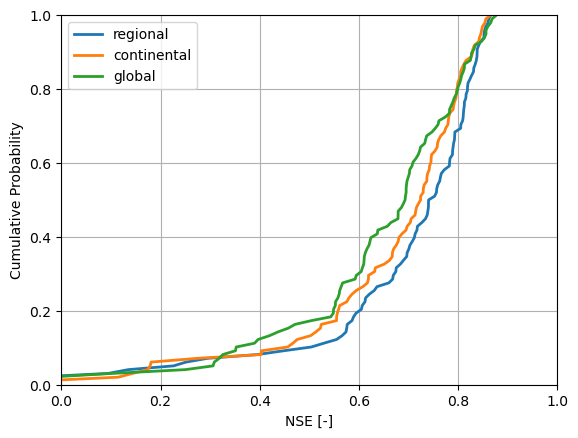

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


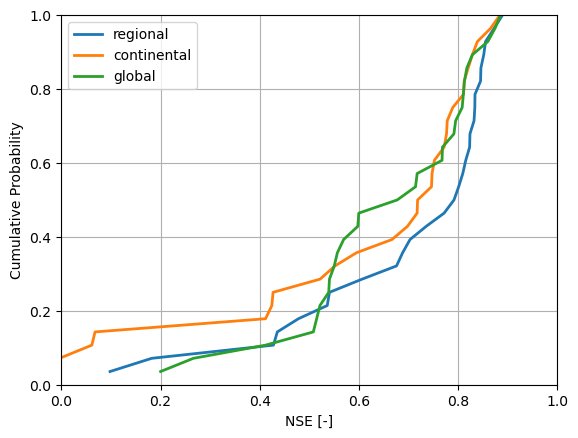

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [59]:
data_diff_val_complete.corr()

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
nse,1.000000,0.139358,0.313295,0.021076,0.228430,-0.248499,-0.678455,-0.093376,-0.223306,0.014473,...,-0.088829,-0.088001,0.106475,-0.050124,-0.036174,0.022932,-0.267772,-0.074758,0.032049,-0.035118
nse_rg,0.139358,1.000000,0.332182,0.306687,-0.299128,0.450059,0.456558,-0.401866,-0.286721,-0.303630,...,-0.152898,-0.148886,0.523524,0.262480,0.037304,-0.439485,-0.320751,-0.334832,-0.164484,0.568303
nse_r1,0.313295,0.332182,1.000000,0.956048,0.800663,0.891752,0.816098,0.524471,-0.514956,-0.463691,...,0.112086,0.112668,0.330516,0.351721,0.297126,0.075319,-0.687991,-0.595461,-0.536491,-0.145586
nse_c1,0.021076,0.306687,0.956048,1.000000,0.772393,0.777664,0.920875,0.432895,-0.473188,-0.492633,...,0.145428,0.145785,0.315086,0.385761,0.323976,0.072214,-0.641627,-0.603807,-0.574702,-0.142427
nse_g1,0.228430,-0.299128,0.800663,0.772393,1.000000,0.609347,0.524179,0.857739,-0.338840,-0.276237,...,0.210512,0.208551,0.001837,0.189099,0.276895,0.355351,-0.492277,-0.389724,-0.438268,-0.508260
nse_bfi_r1,-0.248499,0.450059,0.891752,0.777664,0.609347,1.000000,0.850938,0.603541,-0.347331,-0.729771,...,0.246446,0.237149,0.473454,0.639168,0.589519,0.307747,-0.318486,-0.774473,-0.724501,-0.293918
nse_bfi_c1,-0.678455,0.456558,0.816098,0.920875,0.524179,0.850938,1.000000,0.456600,-0.314001,-0.686820,...,0.244113,0.237208,0.394846,0.628245,0.433511,0.323773,-0.292343,-0.732138,-0.638922,-0.298828
nse_bfi_g1,-0.093376,-0.401866,0.524471,0.432895,0.857739,0.603541,0.456600,1.000000,-0.187665,-0.356587,...,0.242042,0.243547,0.225169,0.318519,0.243414,0.601291,-0.238885,-0.438182,-0.394178,-0.717333
bfi_obs,-0.223306,-0.286721,-0.514956,-0.473188,-0.338840,-0.347331,-0.314001,-0.187665,1.000000,0.658839,...,0.028604,0.027225,-0.709873,-0.653278,-0.413323,-0.359896,0.844838,0.610283,0.441950,0.233044
bfi_r1,0.014473,-0.303630,-0.463691,-0.492633,-0.276237,-0.729771,-0.686820,-0.356587,0.658839,1.000000,...,-0.079177,-0.078609,-0.567581,-0.955843,-0.807205,-0.515054,0.685347,0.936818,0.827184,0.411051


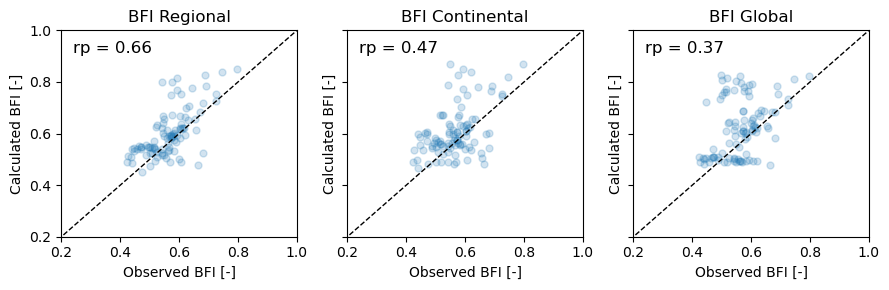

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_cal_complete["bfi_obs"]
    y = data_diff_cal_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_cal_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

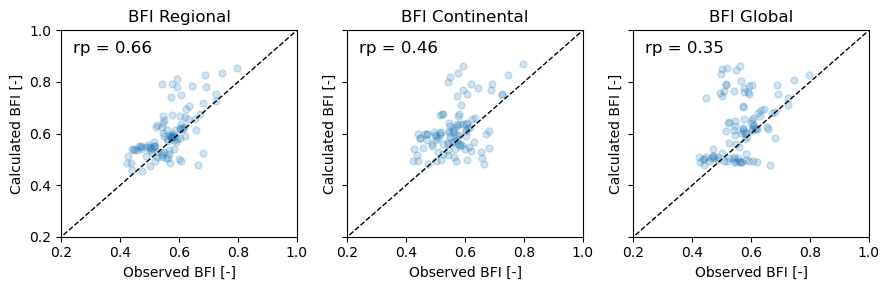

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["bfi_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

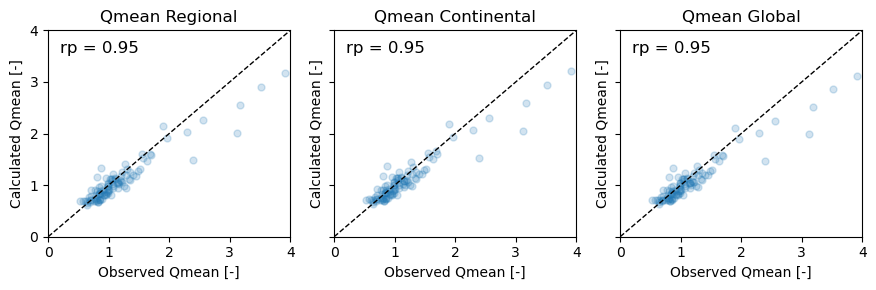

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['qmean_r1', 'qmean_c1', 'qmean_g1']
titles = ['Qmean Regional', 'Qmean Continental', 'Qmean Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["qmean_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 4], [0, 4], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed Qmean [-]")
    ax.set_ylabel("Calculated Qmean [-]")
    ax.set_title(title)
    ax.set_xlim(0.0, 4.0)
    ax.set_ylim(0.0, 4.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

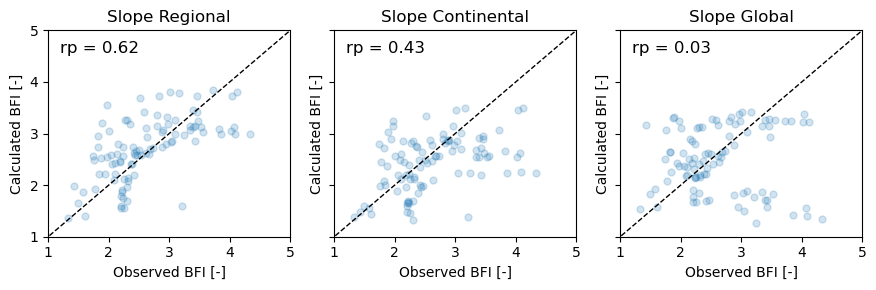

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['slope_r1', 'slope_c1', 'slope_g1']
titles = ['Slope Regional', 'Slope Continental', 'Slope Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["slope_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 5], [0, 5], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed slope [-]")
    ax.set_ylabel("Calculated slope [-]")
    ax.set_title(title)
    ax.set_xlim(1, 5.0)
    ax.set_ylim(1, 5.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

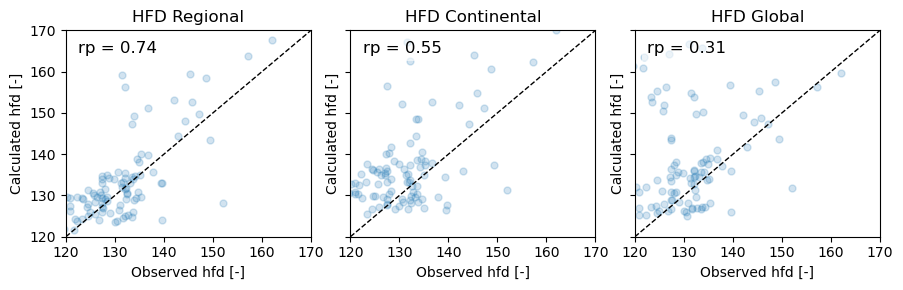

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['hfd_r1', 'hfd_c1', 'hfd_g1']
titles = ['HFD Regional', 'HFD Continental', 'HFD Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["hfd_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([120, 200], [120, 200], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed hfd [-]")
    ax.set_ylabel("Calculated hfd [-]")
    ax.set_title(title)
    ax.set_xlim(120, 170.0)
    ax.set_ylim(120, 170.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

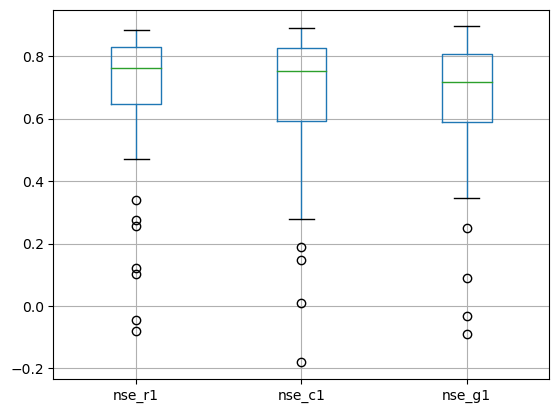

In [67]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal_complete.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


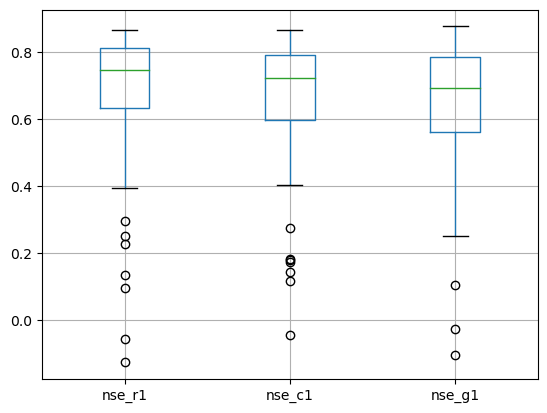

In [68]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_val_complete.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


In [69]:
data_diff_val_complete[data_diff_val_complete.nse_rg > 0.1]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.033513,0.295382,0.838430,0.804917,0.543048,NaN,NaN,NaN,0.515742,0.550943,...,1.258342,1.236424,3.400558,3.121880,2.554032,1.713252,126.294118,129.588235,134.941176,156.176471
BEWA0067,0.047152,0.236029,0.788691,0.741539,0.552662,NaN,NaN,NaN,0.446878,0.537480,...,1.305174,1.300740,3.527884,3.133557,2.543764,1.836960,123.437500,129.187500,137.500000,152.687500
BEWA0106,0.017845,0.413216,0.764083,0.746238,0.350867,NaN,NaN,NaN,0.496805,0.547966,...,1.078355,1.035553,4.063631,3.118763,2.623174,1.562442,127.000000,130.739130,134.869565,164.260870
BEWA0107,0.010444,0.303428,0.740081,0.729637,0.436653,NaN,NaN,NaN,0.565063,0.536219,...,1.443381,1.369701,3.418299,3.138160,2.724969,1.713870,133.588235,134.058824,138.647059,165.823529
BEWA0119,0.025248,0.267249,0.815924,0.790676,0.548675,NaN,NaN,NaN,0.508101,0.545023,...,1.344062,1.301437,3.336434,3.139372,2.679279,1.866495,123.266667,129.400000,133.333333,153.933333
DERP2004,0.011437,0.186581,0.810534,0.799097,0.623953,0.823026,0.777920,0.266025,0.500196,0.545462,...,1.270513,1.228759,3.097860,2.991588,2.704167,1.883520,125.730769,130.038462,132.730769,150.461538
DERP2018,0.028528,0.148110,0.826965,0.798437,0.678854,0.831935,0.828604,0.411934,0.576248,0.584843,...,1.144088,1.116471,2.878603,2.740874,2.849451,1.814825,132.461538,130.384615,128.192308,149.769231
DERP2030,0.015641,0.152471,0.831419,0.815779,0.678949,0.851509,0.838703,0.538953,0.602096,0.582102,...,0.852630,0.830563,2.942743,2.801477,2.659838,1.572786,139.346154,132.961538,134.423077,156.692308
DERP2031,0.013475,0.114997,0.810024,0.796549,0.695027,0.833495,0.820155,0.540472,0.589492,0.566864,...,1.160264,1.132350,3.030842,2.830944,2.852477,1.856316,133.884615,128.884615,128.384615,150.230769


In [70]:
data_diff_val_complete[data_diff_val_complete.nse_rg < 0.1]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
DEBU1956,0.006705,-0.000240,0.855750,0.849045,0.855990,0.872458,0.865388,0.874188,0.602355,0.616877,...,1.103330,1.082242,2.505087,2.681334,2.494619,2.596682,132.038462,131.615385,133.230769,132.653846
DEBU1957,0.004967,0.005334,0.852117,0.847150,0.846783,0.800945,0.812163,0.810387,0.606413,0.638057,...,0.869555,0.858292,2.049171,2.415749,2.196970,2.367540,134.115385,134.807692,136.884615,135.653846
DEBU1959,0.005995,0.001916,0.861675,0.855680,0.859758,0.889248,0.883981,0.885368,0.609882,0.620274,...,1.006374,0.986882,2.526058,2.592754,2.420193,2.418768,132.230769,131.807692,133.653846,134.653846
DERP2005,0.031972,-0.017266,0.789627,0.757655,0.806894,0.823682,0.746171,0.812533,0.445587,0.541195,...,1.074981,1.048957,3.817129,3.092664,2.667322,3.238417,120.192308,129.653846,132.884615,132.153846
DERP2006,0.054154,-0.007420,0.792430,0.738276,0.799850,0.833830,0.718130,0.828641,0.439622,0.540135,...,1.302163,1.273485,4.017057,3.040897,2.536365,3.227473,122.230769,129.692308,135.307692,132.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000009,0.003145,0.026507,0.683503,0.680357,0.656996,NaN,NaN,NaN,0.541148,0.510764,...,0.705583,0.704373,2.358411,3.189876,2.756536,3.131827,132.692308,125.307692,130.923077,126.923077
LU000013,0.008379,0.033131,0.594246,0.585867,0.561115,NaN,NaN,NaN,0.562200,0.505519,...,0.709149,0.708068,2.274642,3.268026,2.811203,3.109251,133.538462,124.846154,130.384615,126.769231
LU000016,-0.038874,0.026691,0.636273,0.675147,0.609581,NaN,NaN,NaN,0.564940,0.522122,...,0.701654,0.700561,2.005883,3.044009,2.571448,3.110440,133.615385,126.000000,132.230769,127.230769


<Axes: >

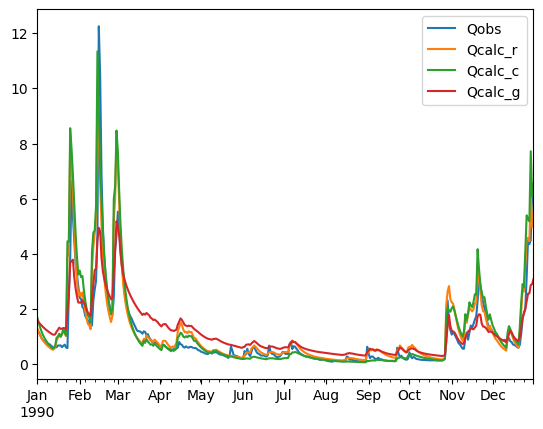

In [71]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1990"].plot()

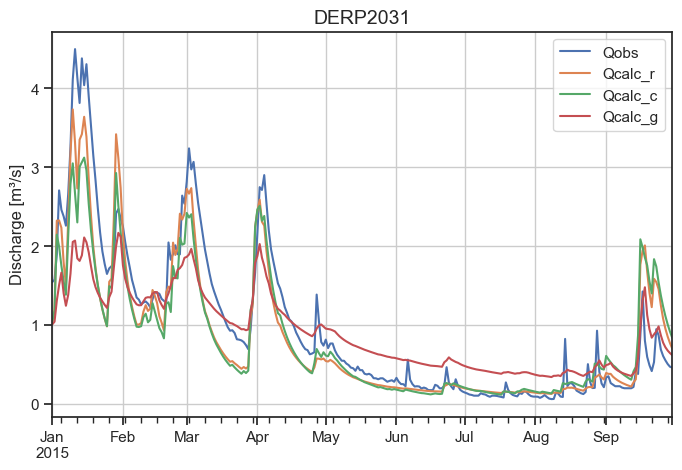

In [221]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

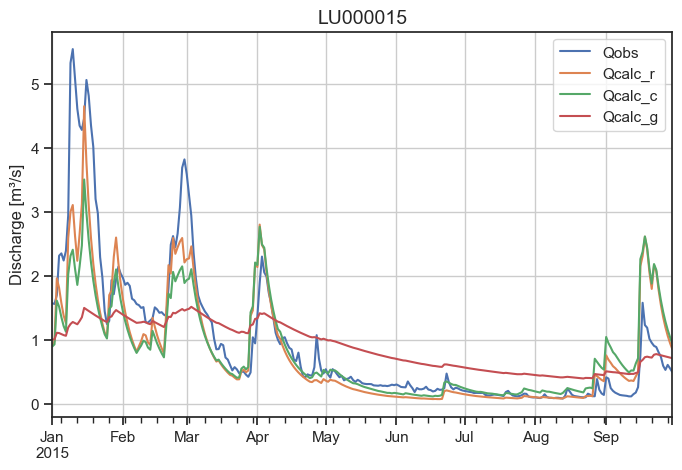

In [220]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000015"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

In [226]:
data_diff_cal_complete.iloc[0:50]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.001149,0.268031,0.851093,0.852243,0.583063,NaN,NaN,NaN,0.515742,0.548718,...,1.351956,1.288932,3.400558,2.976367,2.934487,1.821173,126.294118,131.882353,130.882353,154.176471
BEWA0067,0.009853,0.222910,0.809852,0.799998,0.586941,NaN,NaN,NaN,0.446878,0.532464,...,1.448924,1.376110,3.527884,2.993893,2.914022,1.935750,123.437500,132.562500,131.000000,150.500000
BEWA0106,0.006073,0.412047,0.781766,0.775693,0.369718,NaN,NaN,NaN,0.496805,0.547567,...,1.054775,1.029473,4.063631,3.047146,2.840718,1.628205,127.000000,131.260870,134.739130,163.347826
BEWA0107,-0.014334,0.288461,0.738470,0.752804,0.450010,NaN,NaN,NaN,0.565063,0.536430,...,1.453730,1.372933,3.418299,3.027440,2.860948,1.713635,133.588235,135.705882,134.823529,162.411765
BEWA0119,0.005936,0.264379,0.835513,0.829577,0.571134,NaN,NaN,NaN,0.508101,0.543373,...,1.349761,1.303859,3.336434,3.008043,2.868014,1.877872,123.266667,131.000000,131.600000,152.333333
DEBU1956,0.001204,-0.000377,0.873645,0.872441,0.874023,0.905270,0.894271,0.901646,0.602355,0.617071,...,1.097363,1.078885,2.505087,2.585635,2.600206,2.580150,132.038462,132.307692,132.923077,132.923077
DEBU1957,0.004165,0.004404,0.876563,0.872398,0.872159,0.861301,0.850039,0.855997,0.606413,0.638242,...,0.849564,0.849369,2.049171,2.349275,2.359390,2.380944,134.115385,135.115385,136.730769,135.461538
DEBU1959,-0.000759,0.000406,0.879101,0.879860,0.878696,0.918662,0.908779,0.915312,0.609882,0.620664,...,0.991965,0.980642,2.526058,2.530589,2.472063,2.395559,132.230769,132.230769,133.346154,134.384615
DERP2004,0.020763,0.202898,0.836786,0.816023,0.633888,0.854910,0.792016,0.286371,0.500196,0.547314,...,1.252370,1.218601,3.097860,2.993649,2.747625,1.870203,125.730769,130.500000,132.423077,150.615385


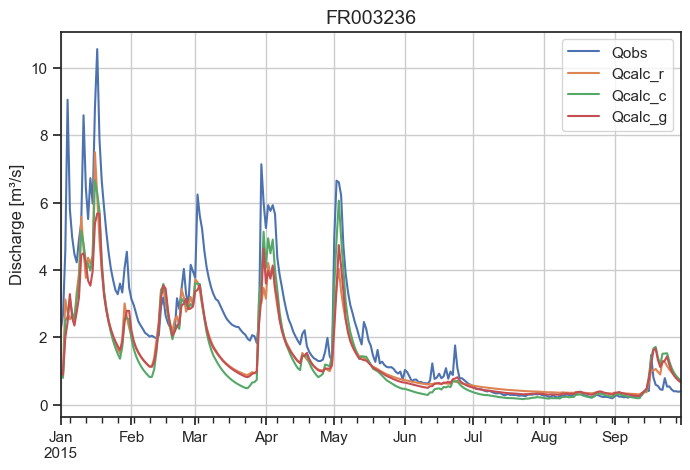

In [231]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003236"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

<Axes: >

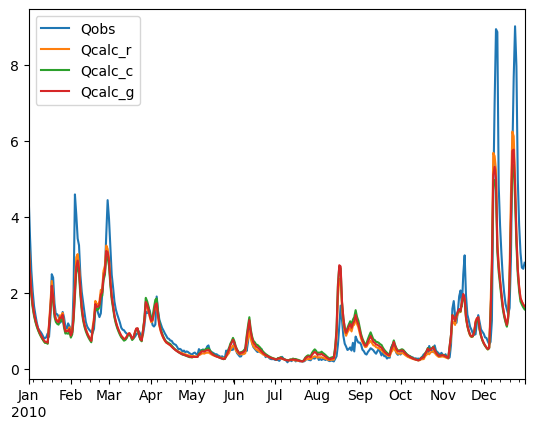

In [131]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DEBU1956"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

<Axes: >

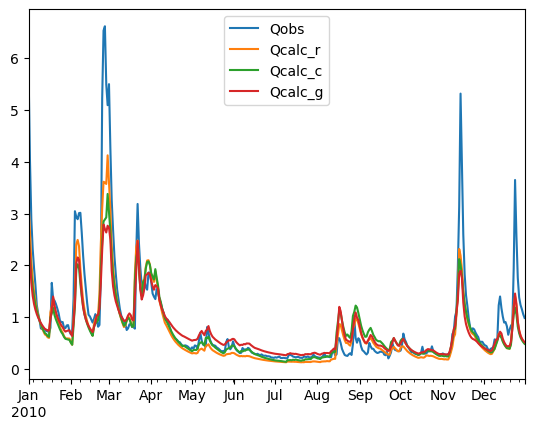

In [75]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

In [78]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.nse < 0.5]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
2,Martelange,BEWA0087,-19.559708,0.715474,0.514520,NaN,0.196649,1.218498,1.740044,2.755850,149.666667,125.416667
18,Contwig,DERP2013,0.176162,0.814145,0.831999,-0.615126,0.650233,0.754420,0.911240,1.612372,161.615385,162.307692
43,A6232010,FR000144,-0.255894,0.678912,0.807192,NaN,1.348492,1.093655,2.280050,1.729140,178.444444,162.111111
53,A9021050,FR000185,0.323610,0.552725,0.785665,NaN,0.774233,1.078687,3.438700,1.665557,157.500000,168.333333
64,La Meurthe Ã Fraize,FR003250,0.179798,0.683506,0.532332,NaN,2.122664,1.416839,1.657028,2.713973,154.250000,132.416667
71,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR003259,0.265702,0.582905,0.740783,NaN,0.835544,1.216135,2.004998,1.907403,143.285714,152.857143
82,Le Woigot Ã Briey,FR003280,0.370471,0.689765,0.505394,NaN,1.295303,0.837186,3.038034,3.257221,138.076923,129.692308
85,Le Canner Ã KÅ“nigsmacker,FR003288,0.463923,0.588279,0.624549,NaN,0.492836,0.617695,1.896325,2.254870,128.846154,136.538462
93,L'Horn Ã Bousseviller,FR003303,-0.444385,0.795316,0.841414,-1.975566,0.592017,0.821343,0.941575,1.585503,154.769231,163.307692
94,La Bisten Ã Creutzwald,FR003306,-0.354898,0.745898,0.807807,NaN,0.536542,0.585222,1.084262,1.514366,153.428571,158.714286


In [79]:
nse_results_cal_c_1_100[nse_results_cal_c_1_100.nse < 0.5]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
2,Martelange,BEWA0087,-20.952601,0.715474,0.541796,NaN,0.196649,1.271732,1.740044,3.133023,149.666667,123.500000
18,Contwig,DERP2013,0.284077,0.814145,0.903759,-0.571054,0.650233,0.758876,0.911240,1.011156,161.615385,178.307692
21,Saarburg,DERP2016,0.312854,0.670428,0.494655,-0.708736,0.790717,0.738667,1.843940,4.011947,141.615385,127.461538
29,Eisenschmitt,DERP2028,0.322533,0.601355,0.895222,-0.036490,0.955417,0.844708,2.127521,1.001812,133.000000,176.461538
30,Dreis,DERP2029,0.437715,0.581470,0.864318,-0.350848,0.719485,0.764893,2.157646,1.117771,133.615385,169.923077
38,A4333010,FR000132,0.357028,0.663813,0.523920,NaN,1.738141,2.182535,1.942057,2.880786,134.636364,122.818182
43,A6232010,FR000144,-0.120584,0.678912,0.789053,NaN,1.348492,1.174152,2.280050,1.358923,178.444444,159.222222
52,A9013050,FR000184,0.494479,0.768679,0.899653,NaN,1.281813,1.146868,1.627801,1.078761,149.666667,175.666667
53,A9021050,FR000185,0.161288,0.552725,0.819895,NaN,0.774233,1.132219,3.438700,1.184193,157.500000,173.833333
64,La Meurthe Ã Fraize,FR003250,0.239730,0.683506,0.539023,NaN,2.122664,1.532101,1.657028,2.899255,154.250000,129.750000


In [80]:
len(nse_results_cal_r_1_100_8801[nse_results_cal_r_1_100_8801.nse < 0.5])

16

In [81]:
len(nse_results_cal_c_1_100_8801[nse_results_cal_c_1_100_8801.nse < 0.5])

16

In [82]:
len(nse_results_cal_g_1_100_8801[nse_results_cal_g_1_100_8801.nse < 0.5])

18

In [179]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


In [83]:
nse_results_cal_r_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.352785
DERP2017    0.867801
DERP2011    0.819390
DERP2013    0.234303
DERP2007    0.856445
DERP2024    0.879439
FR003253    0.773447
FR003283    0.727192
FR003301    0.855149
DERP2003    0.885016
FR003265    0.902029
FR003272    0.880370
DEBU1958    0.902156
Name: nse, dtype: float64

In [84]:
nse_results_cal_c_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.486031
DERP2017    0.841313
DERP2011    0.780354
DERP2013    0.123369
DERP2007    0.820179
DERP2024    0.862515
FR003253    0.793678
FR003283    0.713177
FR003301    0.821363
DERP2003    0.854755
FR003265    0.896927
FR003272    0.877333
DEBU1958    0.889595
Name: nse, dtype: float64

In [85]:
nse_results_cal_g_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.465567
DERP2017    0.730429
DERP2011    0.806612
DERP2013    0.141411
DERP2007    0.866385
DERP2024    0.876119
FR003253    0.808930
FR003283    0.731916
FR003301    0.838486
DERP2003    0.790638
FR003265    0.903852
FR003272    0.884194
DEBU1958    0.895964
Name: nse, dtype: float64

In [86]:
nse_results_cal_r_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.659844
DERP2017    0.838269
DERP2011    0.772581
DERP2013    0.176162
DERP2007    0.804265
DERP2024    0.835266
FR003253    0.765287
FR003283    0.759701
FR003301    0.821211
DERP2003    0.860527
FR003265    0.882589
FR003272    0.851035
DEBU1958    0.899955
Name: nse, dtype: float64

In [87]:
nse_results_cal_c_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.494479
DERP2017    0.806931
DERP2011    0.754340
DERP2013    0.284077
DERP2007    0.791043
DERP2024    0.836585
FR003253    0.755521
FR003283    0.778456
FR003301    0.852679
DERP2003    0.870758
FR003265    0.906480
FR003272    0.865265
DEBU1958    0.914803
Name: nse, dtype: float64

In [88]:
nse_results_cal_g_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.691362
DERP2017    0.750994
DERP2011    0.779291
DERP2013    0.108688
DERP2007    0.828013
DERP2024    0.833642
FR003253    0.793202
FR003283    0.758378
FR003301    0.818336
DERP2003    0.786225
FR003265    0.892816
FR003272    0.859693
DEBU1958    0.898294
Name: nse, dtype: float64

In [137]:
data_diff_val_complete[["lon", "lat"]] = network_estreams[["lon", "lat"]]
data_diff_val_complete

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1,lon,lat
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.033513,0.295382,0.838430,0.804917,0.543048,NaN,NaN,NaN,0.515742,0.550943,...,3.400558,3.121880,2.554032,1.713252,126.294118,129.588235,134.941176,156.176471,6.151802,50.188258
BEWA0067,0.047152,0.236029,0.788691,0.741539,0.552662,NaN,NaN,NaN,0.446878,0.537480,...,3.527884,3.133557,2.543764,1.836960,123.437500,129.187500,137.500000,152.687500,6.263467,50.289277
BEWA0106,0.017845,0.413216,0.764083,0.746238,0.350867,NaN,NaN,NaN,0.496805,0.547966,...,4.063631,3.118763,2.623174,1.562442,127.000000,130.739130,134.869565,164.260870,6.150669,50.196522
BEWA0107,0.010444,0.303428,0.740081,0.729637,0.436653,NaN,NaN,NaN,0.565063,0.536219,...,3.418299,3.138160,2.724969,1.713870,133.588235,134.058824,138.647059,165.823529,6.153955,50.234494
BEWA0119,0.025248,0.267249,0.815924,0.790676,0.548675,NaN,NaN,NaN,0.508101,0.545023,...,3.336434,3.139372,2.679279,1.866495,123.266667,129.400000,133.333333,153.933333,6.141814,50.141935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.054974,0.467338,0.819813,0.764840,0.352475,NaN,NaN,NaN,0.516853,0.551345,...,4.331634,2.995448,2.226096,1.351069,121.769231,124.384615,132.461538,163.615385,6.091178,49.895421
LU000016,-0.038874,0.026691,0.636273,0.675147,0.609581,NaN,NaN,NaN,0.564940,0.522122,...,2.005883,3.044009,2.571448,3.110440,133.615385,126.000000,132.230769,127.230769,6.132266,49.620647
LU000017,0.031045,0.077578,0.860150,0.829105,0.782572,NaN,NaN,NaN,0.572433,0.591535,...,2.459555,2.591746,1.990153,1.716308,127.307692,129.461538,136.692308,144.000000,6.509851,49.785883


In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd

In [170]:
moselle=gpd.read_file(r"..\data\shps\moselle_delienation.shp")
rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

In [262]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


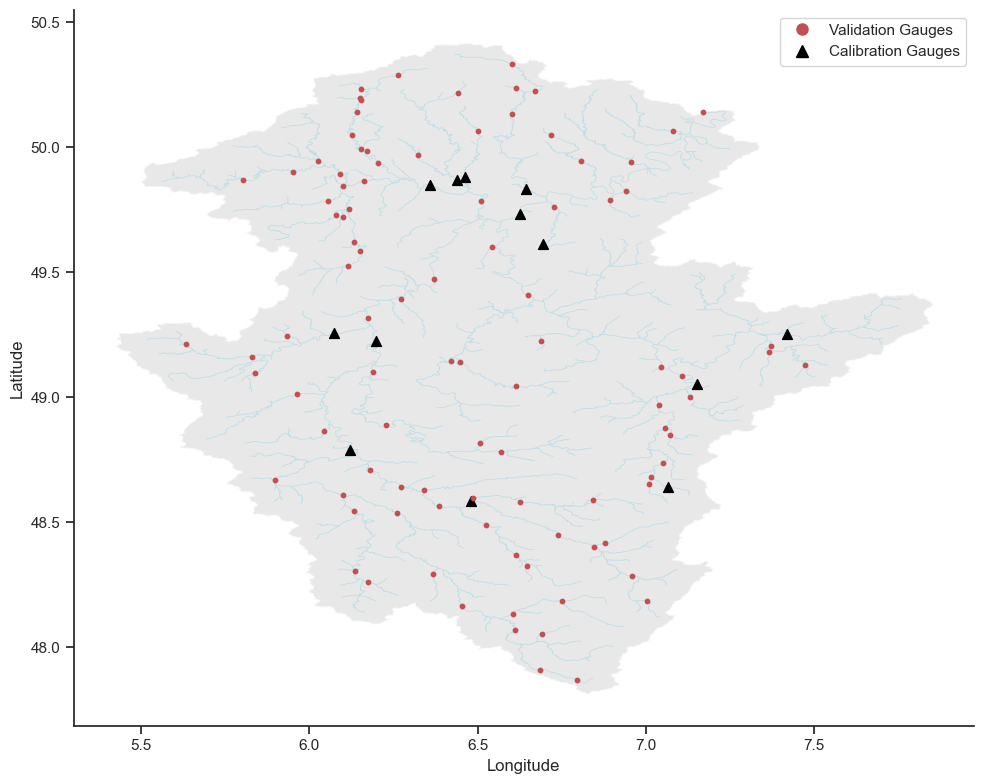

In [263]:
df = data_diff_val_complete.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.scatter(
    df.loc[:, 'lon'],
    df.loc[:, 'lat'],
    marker='o',        # triangle
    color='r',     # black
    s=10,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
#plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


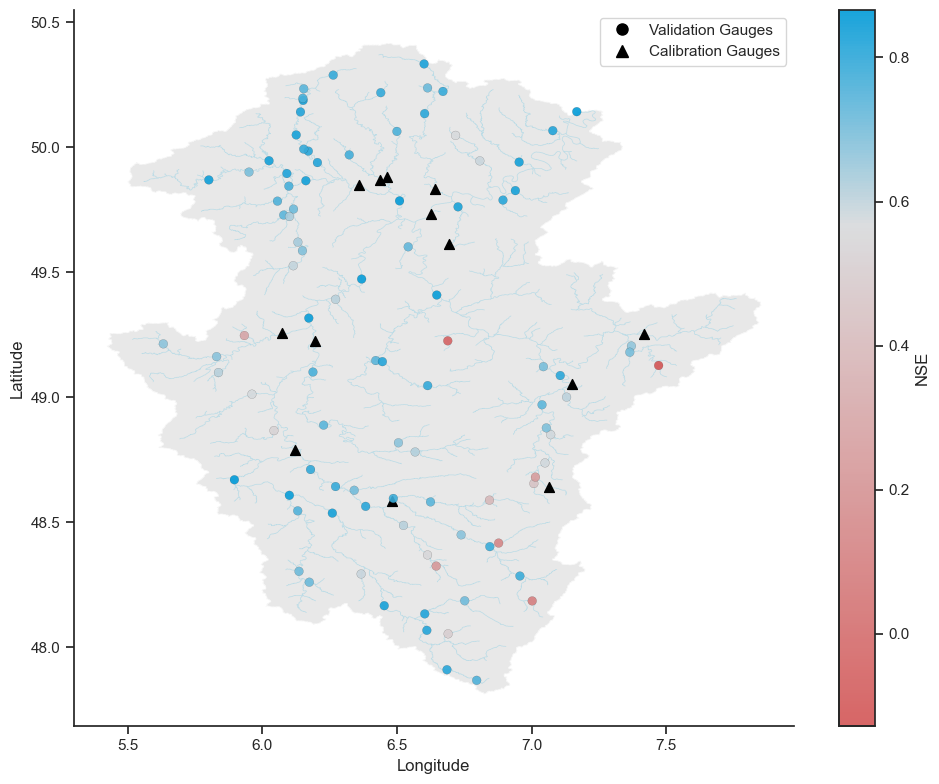

In [264]:
df = data_diff_val_complete.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_r1'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


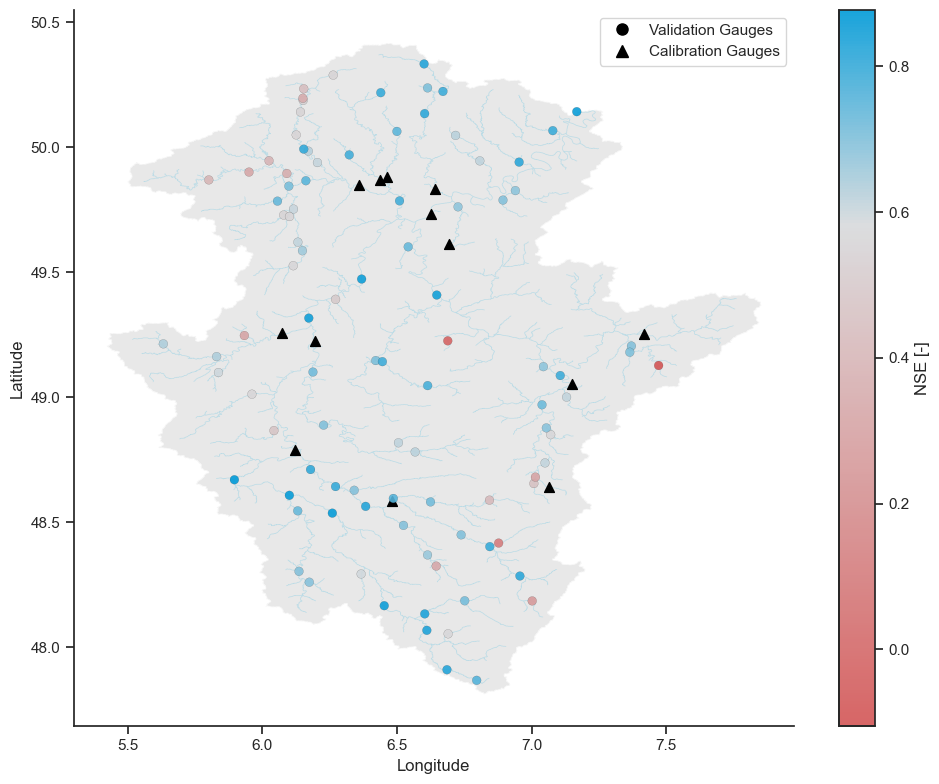

In [ ]:
df = data_diff_val_complete.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_g1'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE [-]", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


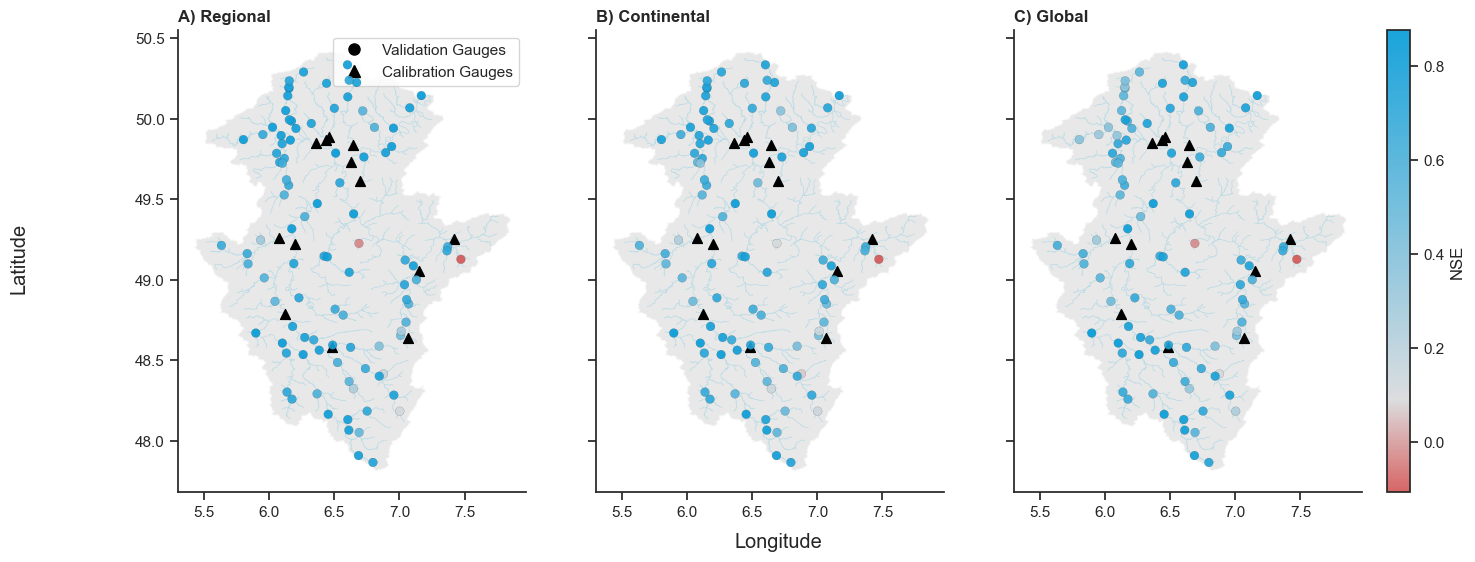

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Create figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)

# NSE columns to plot
nse_cols = ['nse_r1', 'nse_c1', 'nse_g1']
titles = ['A) Regional', 'B) Continental', 'C) Global']

for ax, col, title in zip(axes, nse_cols, titles):
    moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # Calibration basins (triangle)
    ax.scatter(
        network_estreams.loc[list_cal, 'lon'],
        network_estreams.loc[list_cal, 'lat'],
        marker='^',
        color='black',
        s=50,
        zorder=3,
        label='Calibrated Basins'
    )

    # NSE scatter
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    ax.set_title(title, loc="left", fontweight="bold")
    ax.set_aspect('auto')
    ax.grid(False)
    sns.despine(ax=ax)

    # Add legend only to the first plot
    if ax == axes[0]:
        validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                          markersize=8, label='Validation Gauges')
        calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                           markersize=8, label='Calibration Gauges')
        ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')

# Shared labels and colorbar
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

# One colorbar for all
#bar = fig.colorbar(sc, ax=axes.ravel().tolist(), label='NSE', shrink=0.8)
# Add a vertical colorbar on the extreme right
cbar = fig.colorbar(
    sc, 
    ax=axes, 
    orientation='vertical', 
    fraction=0.025,  # controls the thickness
    pad=0.02         # controls the distance from the last subplot
)
cbar.set_label('NSE')

#plt.tight_layout()
plt.show()


<Axes: >

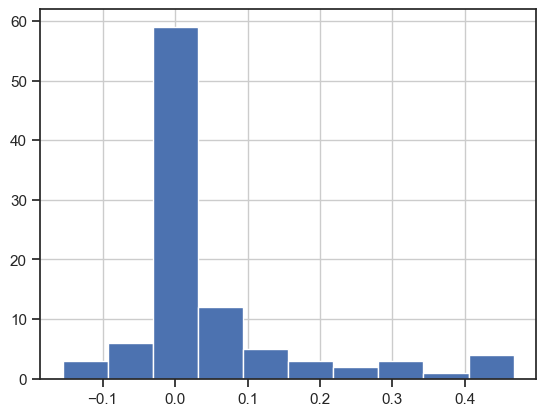

In [195]:
df['nse_rg'].hist()

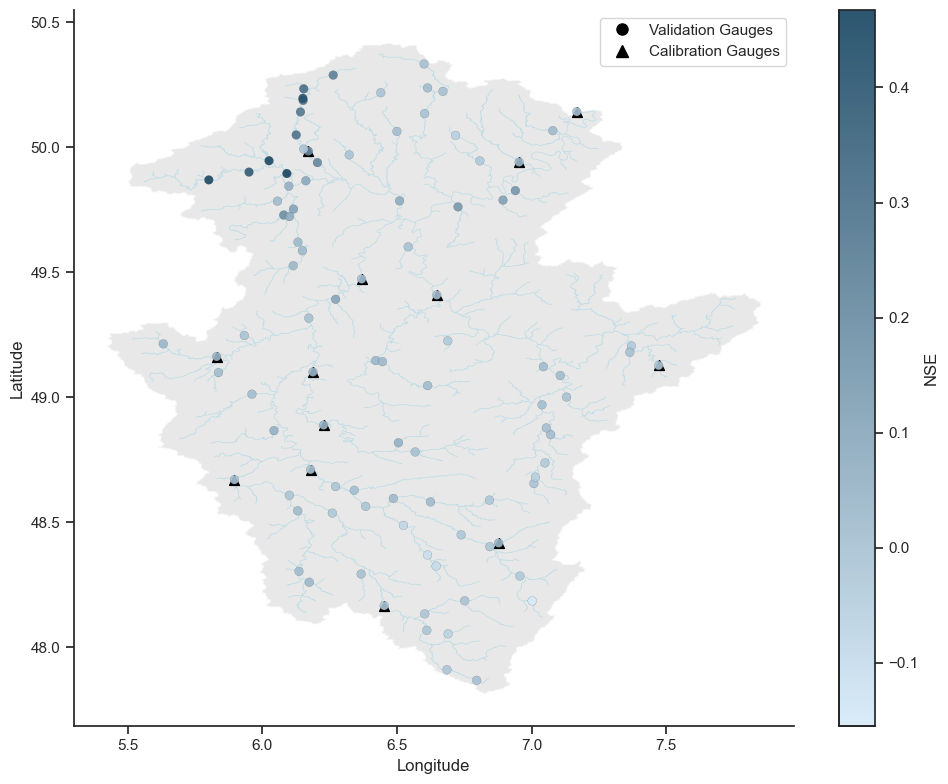

In [ ]:
df = data_diff_val_complete.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)


# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_rg'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


### Group 2: second half

In [212]:
list_cal = ['FR003303',
 'FR000144',
 'DERP2033',
 'FR003275',
 'DERP2004',
 'FR003271',
 #'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']

In [103]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_continental2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2, perm_areas_model = perm_areascontinental)
output_global2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2, perm_areas_model = perm_areasglobal)

nse_results_cal_r_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional2, observations, quality_masks)
nse_results_cal_c_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_continental2, observations, quality_masks)
nse_results_cal_g_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_global2, observations, quality_masks)

path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_continental_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2_8801, perm_areas_model = perm_areascontinental)
output_global_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2_8801, perm_areas_model = perm_areasglobal)

nse_results_cal_r_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_88012, observations, quality_masks)
nse_results_cal_c_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_continental_88012, observations, quality_masks)
nse_results_cal_g_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_global_88012, observations, quality_masks)


path_inputs = '../data/models/input/subset_1988_2001'

observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'

observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()


observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

output_regional_cal2 = {
    key: [np.concatenate([output_regional_88012[key][0], output_regional2[key][0]])]
    for key in output_regional_88012
    if key in output_regional2  # ensures keys match
}

output_continental_cal2 = {
    key: [np.concatenate([output_continental_88012[key][0], output_continental2[key][0]])]
    for key in output_continental_88012
    if key in output_continental2  # ensures keys match
}

output_global_cal2 = {
    key: [np.concatenate([output_global_88012[key][0], output_global2[key][0]])]
    for key in output_global_88012
    if key in output_global2  # ensures keys match
}


nse_results_cal_r_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_cal2, observations_cal, quality_masks_cal)
nse_results_cal_c_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_cal2, observations_cal, quality_masks_cal)
nse_results_cal_g_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_cal2, observations_cal, quality_masks_cal)

c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_18512\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:1

In [104]:
data_diff_cal_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_c_2_100_complete_cal.nse)
data_diff_cal_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_g_2_100_complete_cal.nse

data_diff_cal_complete2.index = nse_results_cal_c_2_100_complete_cal.basin

data_diff_cal_complete2 = data_diff_cal_complete2.loc[~data_diff_cal_complete2.index.isin(list_cal)]

data_diff_cal_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).nse

data_diff_cal_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_obs
data_diff_cal_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim

data_diff_cal_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_obs
data_diff_cal_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim

data_diff_cal_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_obs
data_diff_cal_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).slope_sim

data_diff_cal_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_obs
data_diff_cal_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim


data_diff_cal_complete2 = data_diff_cal_complete2[data_diff_cal_complete2.nse_r1 > -10.0]
data_diff_cal_complete2

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.025793,0.310020,0.829036,0.854830,0.519017,NaN,NaN,NaN,0.515742,0.573456,...,1.307285,1.234615,3.400558,2.743290,3.195068,1.777066,126.294118,137.294118,130.352941,159.352941
BEWA0067,-0.034845,0.234069,0.768075,0.802919,0.534006,NaN,NaN,NaN,0.446878,0.560397,...,1.397150,1.323675,3.527884,2.698627,3.134984,1.860673,123.437500,138.937500,130.562500,154.750000
BEWA0106,-0.029836,0.487017,0.763070,0.792906,0.276053,NaN,NaN,NaN,0.496805,0.572535,...,1.021858,0.983790,4.063631,2.783658,3.291014,1.591152,127.000000,136.521739,133.000000,171.000000
BEWA0107,-0.002470,0.396842,0.759315,0.761785,0.362473,NaN,NaN,NaN,0.565063,0.557326,...,1.429620,1.321399,3.418299,2.795479,3.137608,1.671909,133.588235,141.411765,133.941176,168.588235
BEWA0119,-0.015906,0.310934,0.816860,0.832765,0.505925,NaN,NaN,NaN,0.508101,0.567503,...,1.325504,1.260757,3.336434,2.753243,3.131224,1.822339,123.266667,136.400000,130.600000,157.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.060333,0.383704,0.784399,0.844733,0.400695,NaN,NaN,NaN,0.516853,0.570479,...,1.013724,0.962041,4.331634,2.573227,3.314807,1.744927,121.769231,135.076923,128.000000,164.692308
LU000016,0.113749,0.058466,0.657855,0.544106,0.599389,NaN,NaN,NaN,0.564940,0.555673,...,0.696155,0.690550,2.005883,2.774134,3.753879,3.276128,133.615385,134.384615,130.076923,130.538462
LU000017,-0.018020,0.066757,0.844705,0.862725,0.777947,NaN,NaN,NaN,0.572433,0.606628,...,0.873031,0.845101,2.459555,2.377061,2.690857,1.983503,127.307692,137.769231,133.076923,147.846154


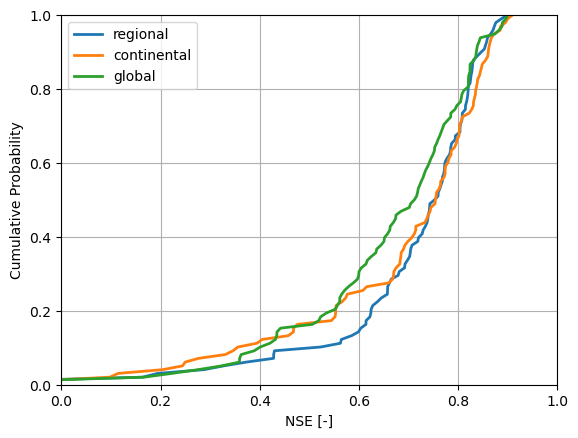

In [105]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

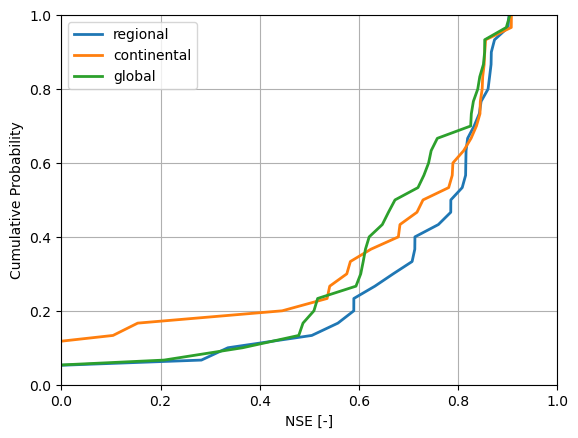

In [106]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


#### Validation

In [108]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_continental_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2, perm_areas_model = perm_areascontinental)
output_global_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2, perm_areas_model = perm_areasglobal)

path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_continental_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2_8801, perm_areas_model = perm_areascontinental)
output_global_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2_8801, perm_areas_model = perm_areasglobal)

In [109]:
output_regional_val_c2 = {
    key: [np.concatenate([output_regional_val2[key][0], output_regional_01152[key][0]])]
    for key in output_regional_01152
    if key in output_regional_val2  # ensures keys match
}

output_continental_val_c2 = {
    key: [np.concatenate([output_continental_val2[key][0], output_continental_01152[key][0]])]
    for key in output_continental_val2
    if key in output_continental_01152  # ensures keys match
}

output_global_val_c2 = {
    key: [np.concatenate([output_global_val2[key][0], output_global_01152[key][0]])]
    for key in output_global_val2
    if key in output_global_01152  # ensures keys match
}

In [110]:
nse_results_cal_r_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_val_c2, observations_cal, quality_masks_cal)
nse_results_cal_c_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_val_c2, observations_cal, quality_masks_cal)
nse_results_cal_g_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_val_c2, observations_cal, quality_masks_cal)

In [134]:
data_diff_val_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_c_2_100_complete_val.nse)
data_diff_val_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_g_2_100_complete_val.nse

data_diff_val_complete2.index = nse_results_cal_c_2_100_complete_val.basin

data_diff_val_complete2 = data_diff_val_complete2.loc[~data_diff_val_complete2.index.isin(list_cal)]

data_diff_val_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).nse

data_diff_val_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_obs
data_diff_val_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).bfi_sim

data_diff_val_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_obs
data_diff_val_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).qmean_sim

data_diff_val_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_obs
data_diff_val_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).slope_sim

data_diff_val_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_obs
data_diff_val_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).hfd_sim


data_diff_val_complete2 = data_diff_val_complete2[data_diff_val_complete2.nse_r1 > -10.0]
data_diff_val_complete2




,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.005718,0.355179,0.821671,0.827389,0.466492,NaN,NaN,NaN,0.515742,0.571076,...,1.229881,1.190466,3.400558,2.868569,3.061155,1.599769,126.294118,135.352941,132.058824,163.529412
BEWA0067,-0.009087,0.261289,0.755194,0.764281,0.493905,NaN,NaN,NaN,0.446878,0.555953,...,1.289278,1.264698,3.527884,2.914973,3.098414,1.715402,123.437500,136.937500,133.937500,158.187500
BEWA0106,-0.024381,0.494743,0.750625,0.775006,0.255882,NaN,NaN,NaN,0.496805,0.571488,...,1.026590,0.976160,4.063631,2.857153,3.179807,1.408204,127.000000,136.086957,133.043478,173.478261
BEWA0107,0.010143,0.427166,0.761236,0.751093,0.334070,NaN,NaN,NaN,0.565063,0.555682,...,1.408629,1.316139,3.418299,2.874452,3.142920,1.562104,133.588235,139.411765,135.470588,175.529412
BEWA0119,-0.002562,0.319474,0.804388,0.806950,0.484914,NaN,NaN,NaN,0.508101,0.565601,...,1.308257,1.251409,3.336434,2.884838,3.082609,1.748002,123.266667,134.800000,130.933333,160.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.008877,0.594414,0.808341,0.817218,0.213927,NaN,NaN,NaN,0.516853,0.571037,...,0.906454,0.889642,4.331634,2.747176,2.931268,1.237538,121.769231,129.923077,129.461538,174.846154
LU000016,0.032608,0.082443,0.612132,0.579524,0.529689,NaN,NaN,NaN,0.564940,0.555008,...,0.638566,0.644934,2.005883,2.862135,3.078900,3.457008,133.615385,130.461538,129.923077,127.000000
LU000017,0.003530,0.087533,0.834798,0.831269,0.747265,NaN,NaN,NaN,0.572433,0.610980,...,0.787699,0.785198,2.459555,2.438855,2.459436,1.693942,127.307692,134.307692,134.538462,147.230769


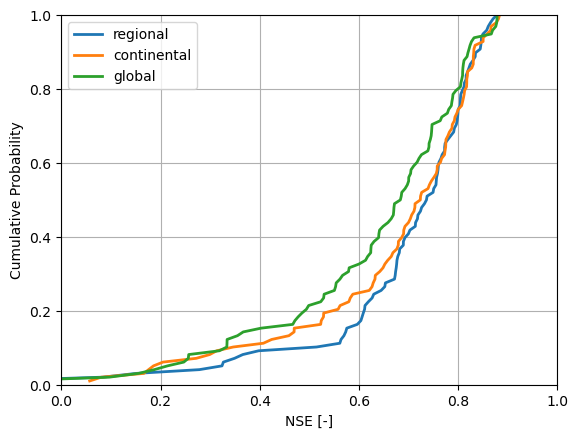

In [135]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

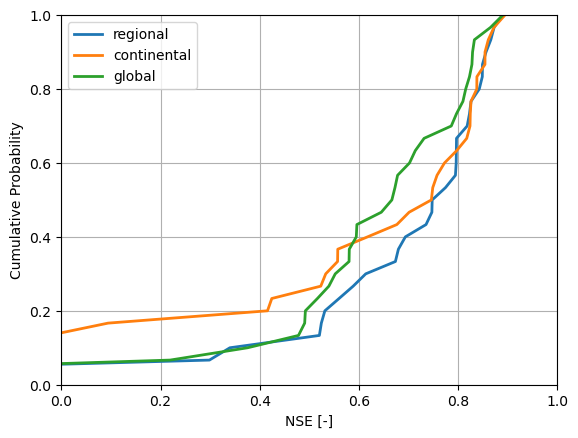

In [115]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

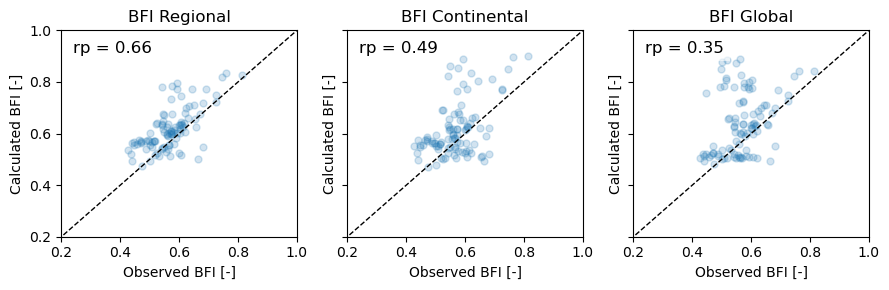

In [117]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["bfi_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

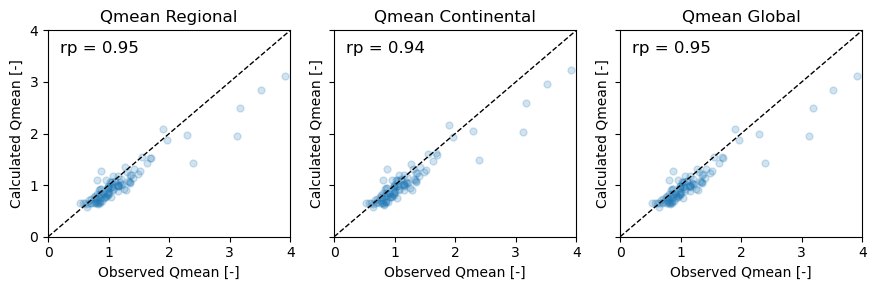

In [119]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['qmean_r1', 'qmean_c1', 'qmean_g1']
titles = ['Qmean Regional', 'Qmean Continental', 'Qmean Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["qmean_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 4], [0, 4], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed Qmean [-]")
    ax.set_ylabel("Calculated Qmean [-]")
    ax.set_title(title)
    ax.set_xlim(0.0, 4.0)
    ax.set_ylim(0.0, 4.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

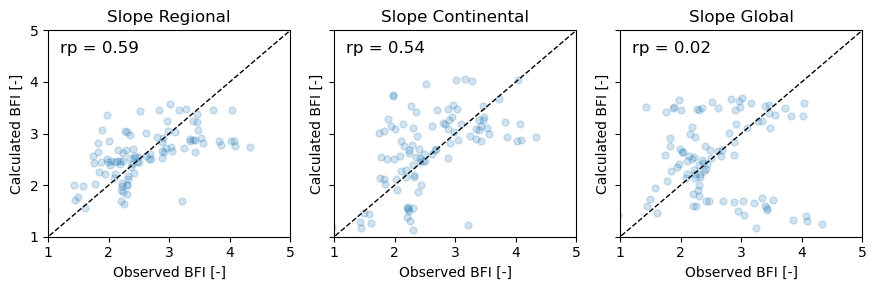

In [121]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['slope_r1', 'slope_c1', 'slope_g1']
titles = ['Slope Regional', 'Slope Continental', 'Slope Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["slope_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 5], [0, 5], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(1, 5.0)
    ax.set_ylim(1, 5.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

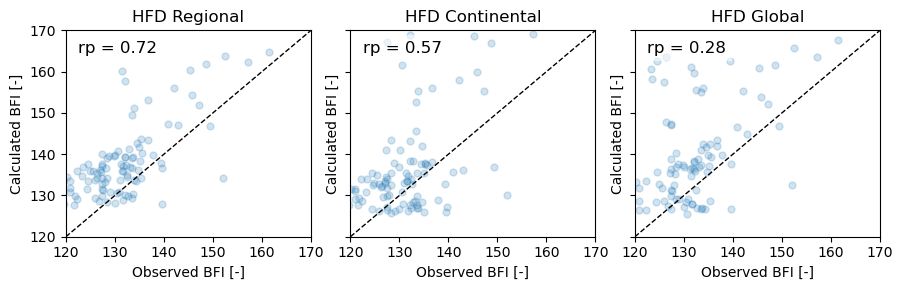

In [122]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['hfd_r1', 'hfd_c1', 'hfd_g1']
titles = ['HFD Regional', 'HFD Continental', 'HFD Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["hfd_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([120, 200], [120, 200], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(120, 170.0)
    ax.set_ylim(120, 170.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

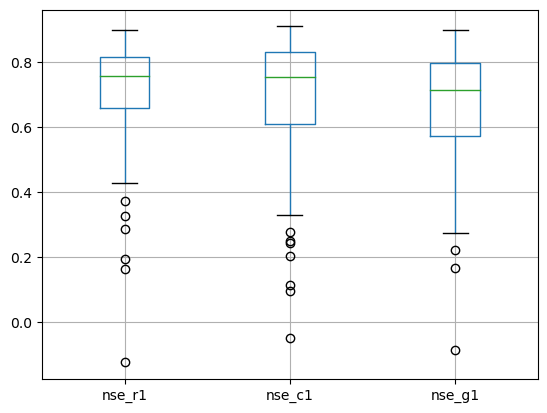

In [124]:


# Plot both columns side by side
data_diff_cal_complete2.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()



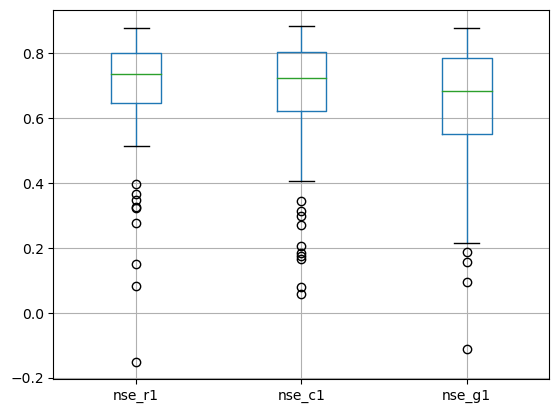

In [125]:


# Plot both columns side by side
data_diff_val_complete2.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()



In [127]:
data_diff_val_complete2[data_diff_val_complete2.nse_r1 < 0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
DERP2013,-0.083075,-0.013097,0.083079,0.166154,0.096176,-0.585098,-0.408345,-0.554157,0.813898,0.827653,...,0.771586,0.778427,0.958560,1.524482,1.192806,1.417545,161.346154,164.807692,179.538462,167.653846
FR000183,-0.009516,-0.004917,0.397711,0.407226,0.402628,NaN,NaN,NaN,0.726346,0.747846,...,1.053525,1.040745,2.204864,1.898045,1.555593,1.833309,147.250000,151.958333,155.250000,152.041667
FR000184,0.180012,0.010754,0.365726,0.185714,0.354972,NaN,NaN,NaN,0.760768,0.832815,...,1.076194,1.069917,1.439657,1.711659,1.161932,1.601227,152.480000,163.760000,179.160000,165.840000
FR000185,0.147979,0.005401,0.323789,0.175810,0.318388,NaN,NaN,NaN,0.541713,0.779659,...,1.106566,1.096805,3.206302,1.692572,1.223568,1.651249,145.277778,160.444444,168.611111,160.833333
FR003250,0.070088,-0.005127,0.150458,0.080370,0.155585,NaN,NaN,NaN,0.680834,0.547678,...,1.490959,1.438213,1.818016,2.818138,3.039606,2.907354,152.040000,134.120000,130.080000,132.600000
FR003254,-0.019839,-0.007303,0.326564,0.346403,0.333867,NaN,NaN,NaN,0.723597,0.723494,...,0.901611,0.898634,1.571402,1.975920,1.441068,1.941028,148.625000,161.875000,167.000000,161.500000
FR003259,0.073407,-0.088387,0.278223,0.204816,0.366610,NaN,NaN,NaN,0.570623,0.732099,...,1.305717,1.279329,2.215223,2.042469,1.546628,2.545800,136.647059,153.176471,156.058824,143.411765
FR003280,0.050043,0.015513,0.349008,0.298965,0.333495,NaN,NaN,NaN,0.664153,0.501144,...,0.942279,0.919787,3.012886,3.564313,4.041586,3.689990,139.576923,127.807692,125.884615,126.769231
FR003306,-0.210191,-0.040751,-0.153152,0.057039,-0.112401,NaN,NaN,NaN,0.747143,0.818040,...,0.617547,0.630695,1.611967,1.551600,1.269791,1.468984,157.166667,162.388889,169.222222,163.611111


In [128]:
data_diff_val_complete2[data_diff_val_complete2.nse_g1 < 0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.005718,0.355179,0.821671,0.827389,0.466492,NaN,NaN,NaN,0.515742,0.571076,...,1.229881,1.190466,3.400558,2.868569,3.061155,1.599769,126.294118,135.352941,132.058824,163.529412
BEWA0067,-0.009087,0.261289,0.755194,0.764281,0.493905,NaN,NaN,NaN,0.446878,0.555953,...,1.289278,1.264698,3.527884,2.914973,3.098414,1.715402,123.437500,136.937500,133.937500,158.187500
BEWA0106,-0.024381,0.494743,0.750625,0.775006,0.255882,NaN,NaN,NaN,0.496805,0.571488,...,1.026590,0.976160,4.063631,2.857153,3.179807,1.408204,127.000000,136.086957,133.043478,173.478261
BEWA0107,0.010143,0.427166,0.761236,0.751093,0.334070,NaN,NaN,NaN,0.565063,0.555682,...,1.408629,1.316139,3.418299,2.874452,3.142920,1.562104,133.588235,139.411765,135.470588,175.529412
BEWA0119,-0.002562,0.319474,0.804388,0.806950,0.484914,NaN,NaN,NaN,0.508101,0.565601,...,1.308257,1.251409,3.336434,2.884838,3.082609,1.748002,123.266667,134.800000,130.933333,160.666667
DERP2013,-0.083075,-0.013097,0.083079,0.166154,0.096176,-0.585098,-0.408345,-0.554157,0.813898,0.827653,...,0.771586,0.778427,0.958560,1.524482,1.192806,1.417545,161.346154,164.807692,179.538462,167.653846
FR000183,-0.009516,-0.004917,0.397711,0.407226,0.402628,NaN,NaN,NaN,0.726346,0.747846,...,1.053525,1.040745,2.204864,1.898045,1.555593,1.833309,147.250000,151.958333,155.250000,152.041667
FR000184,0.180012,0.010754,0.365726,0.185714,0.354972,NaN,NaN,NaN,0.760768,0.832815,...,1.076194,1.069917,1.439657,1.711659,1.161932,1.601227,152.480000,163.760000,179.160000,165.840000
FR000185,0.147979,0.005401,0.323789,0.175810,0.318388,NaN,NaN,NaN,0.541713,0.779659,...,1.106566,1.096805,3.206302,1.692572,1.223568,1.651249,145.277778,160.444444,168.611111,160.833333


In [214]:
data_diff_val_complete2[["lon", "lat"]] = network_estreams[["lon", "lat"]]

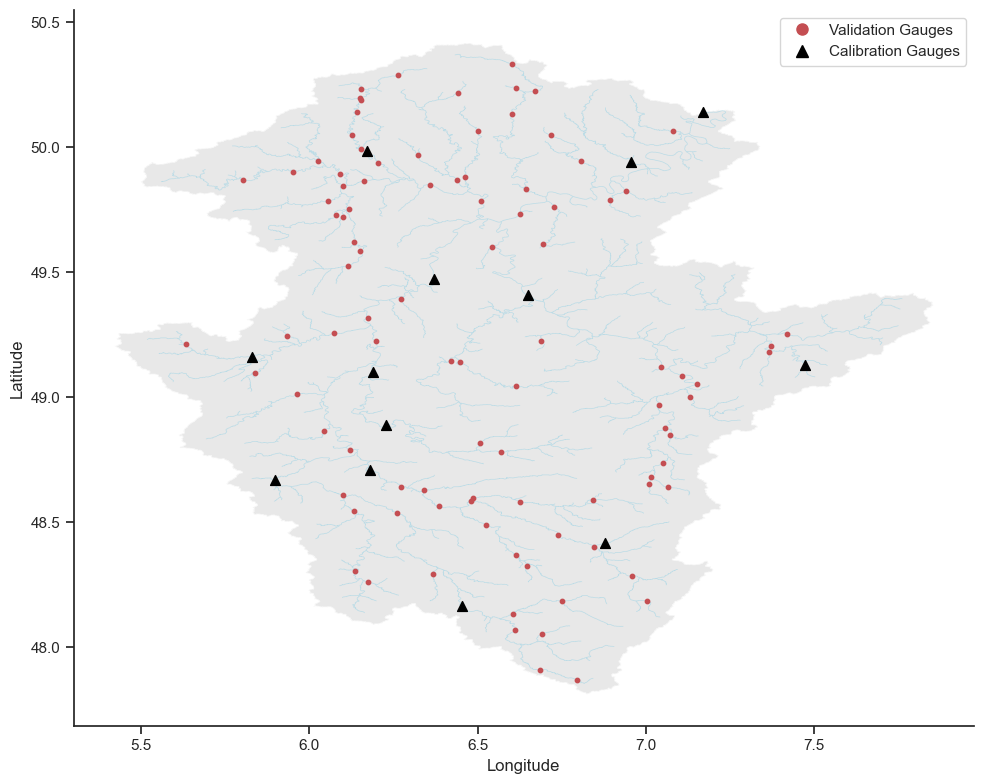

In [252]:
df = data_diff_val_complete2.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.scatter(
    df.loc[:, 'lon'],
    df.loc[:, 'lat'],
    marker='o',        # triangle
    color='r',     # black
    s=10,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
#plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


In [ ]:
LU000016

In [251]:
perm_areasglobal

{'BEWA0066': [0.75, 0.25, 0.0],
 'BEWA0067': [0.64, 0.36, 0.0],
 'BEWA0087': [1.0, 0.0, 0.0],
 'BEWA0106': [1.0, 0.0, 0.0],
 'BEWA0107': [1.0, 0.0, 0.0],
 'BEWA0119': [0.75, 0.25, 0.0],
 'DEBU1956': [0.19, 0.73, 0.08],
 'DEBU1957': [0.33, 0.66, 0.01],
 'DEBU1958': [0.28, 0.68, 0.04],
 'DEBU1959': [0.31, 0.65, 0.04],
 'DERP2003': [0.5, 0.5, 0.0],
 'DERP2004': [0.59, 0.41, 0.0],
 'DERP2005': [0.0, 1.0, 0.0],
 'DERP2006': [0.0, 1.0, 0.0],
 'DERP2007': [0.07, 0.93, 0.0],
 'DERP2008': [0.01, 0.99, 0.0],
 'DERP2010': [0.23, 0.77, 0.0],
 'DERP2011': [0.23, 0.77, 0.0],
 'DERP2013': [0.92, 0.08, 0.0],
 'DERP2014': [0.67, 0.33, 0.0],
 'DERP2015': [0.49, 0.51, 0.0],
 'DERP2016': [0.32, 0.68, 0.0],
 'DERP2017': [0.74, 0.26, 0.0],
 'DERP2018': [0.75, 0.25, 0.0],
 'DERP2021': [0.02, 0.98, 0.0],
 'DERP2022': [0.14, 0.76, 0.1],
 'DERP2023': [0.14, 0.77, 0.09],
 'DERP2024': [0.3, 0.65, 0.05],
 'DERP2027': [0.18, 0.78, 0.04],
 'DERP2028': [0.79, 0.2, 0.01],
 'DERP2029': [0.75, 0.25, 0.0],
 'DERP2030': [

In [248]:
data_diff_val_complete.iloc[50:]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1,lon,lat
basin,,,,,,,,,,,,,,,,,,,,,
FR003237,-0.010695,-0.025205,0.830886,0.841580,0.856091,0.845793,0.810661,0.859823,0.582925,0.573563,...,2.455219,2.656551,2.647317,2.619848,132.269231,129.038462,129.884615,131.346154,6.452981,48.165666
FR003239,0.009453,-0.003134,0.588980,0.579528,0.592114,NaN,NaN,NaN,0.541757,0.624275,...,1.733716,2.572342,2.804096,2.512157,127.391304,133.130435,129.086957,133.521739,6.367100,48.292520
FR003241,-0.007894,-0.027964,0.837770,0.845664,0.865734,NaN,NaN,NaN,0.572007,0.591357,...,2.665677,2.601466,2.564830,2.552515,127.500000,127.045455,127.954545,129.000000,6.260215,48.536107
FR003246,0.015625,0.018337,0.752508,0.736883,0.734171,NaN,NaN,NaN,0.470773,0.550802,...,2.979324,3.181073,2.780996,3.241284,120.840000,127.440000,130.720000,127.040000,6.131546,48.545356
FR003249,-0.000189,-0.011399,0.865700,0.865889,0.877099,NaN,NaN,NaN,0.579674,0.597453,...,2.729270,2.721966,2.555754,2.670418,128.307692,129.653846,131.000000,130.884615,5.896402,48.669764
FR003250,-0.084235,-0.155093,0.094741,0.178975,0.249834,NaN,NaN,NaN,0.680834,0.526290,...,1.818016,2.954627,2.715800,2.650297,152.040000,128.280000,131.240000,131.800000,7.002529,48.184730
FR003251,0.067694,-0.014822,0.783474,0.715780,0.798296,NaN,NaN,NaN,0.628729,0.654936,...,2.109643,2.213135,2.603438,2.187480,137.863636,135.636364,129.590909,137.136364,6.845062,48.402032
FR003252,0.055869,-0.021724,0.675042,0.619172,0.696766,NaN,NaN,NaN,0.669344,0.675448,...,2.087440,2.098826,2.495875,2.182795,149.333333,143.333333,137.416667,143.583333,6.738613,48.449237
FR003254,-0.071523,-0.024247,0.395169,0.466692,0.419416,NaN,NaN,NaN,0.723597,0.725719,...,1.571402,1.875206,1.556467,1.926381,148.625000,158.500000,160.625000,157.375000,6.843861,48.588049
